# 暗号資産市場における「サイズ効果」検証

本ノートブックでは、暗号資産市場において銘柄の「出来高規模（サイズ）」によってテクニカル指標（21日リターン）の有効性がどのように変化するかを検証します。

## 検証の仮説
- **大型銘柄**: モメンタム（順張り）が効きやすい、あるいは傾向が不明瞭
- **小型銘柄**: 強いリバーサル（逆張り）特性が見られる

## データソース
- **取引所**: Binance無期限先物（Perpetual）
- **期間**: 2023年1月1日 〜 現在
- **対象**: 平均日次出来高が1M USD以上の銘柄


In [1]:
# 1. 必要なライブラリのインポート

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ccxt
import warnings
from datetime import datetime, timedelta
from tqdm import tqdm
import time

# 日本語フォントの設定
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

print("ライブラリのインポート完了")


ライブラリのインポート完了


In [42]:
# 2. Binanceデータ取得の設定

# Binance先物取引所の設定
exchange = ccxt.binance({
    'apiKey': '',  # APIキーが必要な場合は設定
    'secret': '',
    'sandbox': False,
    'options': {
        'defaultType': 'future'  # 先物取引を指定
    }
})

# データ取得期間の設定
start_date = datetime(2023, 1, 1)
end_date = datetime.now()

print(f"データ取得期間: {start_date.strftime('%Y-%m-%d')} 〜 {end_date.strftime('%Y-%m-%d')}")
print(f"取得期間: {(end_date - start_date).days} 日間")


データ取得期間: 2023-01-01 〜 2026-01-15
取得期間: 1110 日間


In [43]:
# 3. 先物銘柄の取得とフィルタリング

def get_futures_symbols():
    """Binance先物の銘柄一覧を取得"""
    markets = exchange.load_markets()
    
    # USDTペアの先物銘柄のみを抽出
    futures_symbols = [symbol for symbol, market in markets.items() 
                      if market['type'] == 'swap' and symbol.endswith('USDT')]
    
    print(f"取得可能な先物銘柄数: {len(futures_symbols)}")
    return futures_symbols

def get_historical_data(symbol, start_date, end_date, timeframe='1d'):
    """指定銘柄の日足データを取得"""
    try:
        since = int(start_date.timestamp() * 1000)
        limit = 1000  # 1回で取得できる最大データ数
        
        all_ohlcv = []
        current_since = since
        
        while current_since < int(end_date.timestamp() * 1000):
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, current_since, limit)
            if not ohlcv:
                break
                
            all_ohlcv.extend(ohlcv)
            current_since = ohlcv[-1][0] + 86400000  # 1日分進める
            time.sleep(0.1)  # レート制限対策
            
        if all_ohlcv:
            df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            df['symbol'] = symbol
            return df
        else:
            return None
            
    except Exception as e:
        print(f"エラー: {symbol} - {str(e)}")
        return None

# 銘柄一覧の取得
futures_symbols = get_futures_symbols()
print(f"対象銘柄例: {futures_symbols[:10]}")


取得可能な先物銘柄数: 615
対象銘柄例: ['BTC/USDT:USDT', 'ETH/USDT:USDT', 'BCH/USDT:USDT', 'XRP/USDT:USDT', 'LTC/USDT:USDT', 'TRX/USDT:USDT', 'ETC/USDT:USDT', 'LINK/USDT:USDT', 'XLM/USDT:USDT', 'ADA/USDT:USDT']


In [47]:
# 4. 全銘柄のデータ収集とフィルタリング



def collect_and_filter_data(symbols, start_date, end_date, min_volume_usd=1_000_000):
    """
    全銘柄のデータを収集し、出来高でフィルタリング
    
    Parameters:
    - symbols: 対象銘柄リスト
    - start_date, end_date: データ取得期間
    - min_volume_usd: 最小平均日次出来高（USD）
    """
    all_data = []
    valid_symbols = []
    
    print("データ収集中...")
    for i, symbol in enumerate(tqdm(symbols)):
        df = get_historical_data(symbol, start_date, end_date)
        
        if df is not None and len(df) > 100:  # 最低100日のデータが必要
            # USD出来高の計算
            df['volume_usd'] = df['close'] * df['volume']
            avg_volume_usd = df['volume_usd'].mean()
            
            # 出来高フィルタリング
            if avg_volume_usd >= min_volume_usd:
                df['returns'] = df['close'].pct_change()
                all_data.append(df)
                valid_symbols.append(symbol)
                print(f"✓ {symbol}: 平均出来高 ${avg_volume_usd:,.0f}")
            else:
                print(f"✗ {symbol}: 出来高不足 ${avg_volume_usd:,.0f}")
                
        if i % 10 == 0 and i > 0:
            print(f"進捗: {i}/{len(symbols)}")
            time.sleep(1)  # レート制限対策
    
    if all_data:
        # 全データを結合
        combined_data = pd.concat(all_data, ignore_index=False)
        print(f"\n有効銘柄数: {len(valid_symbols)}")
        print(f"総データポイント数: {len(combined_data):,}")
        
        return combined_data, valid_symbols
    else:
        print("有効なデータが取得できませんでした")
        return None, []

# データ収集の実行
print("データ収集を開始します（時間がかかる場合があります）...")
market_data, valid_symbols = collect_and_filter_data(futures_symbols, start_date, end_date)


データ収集を開始します（時間がかかる場合があります）...
データ収集中...


  0%|          | 1/615 [00:00<03:47,  2.70it/s]

✓ BTC/USDT:USDT: 平均出来高 $15,340,018,616


  0%|          | 2/615 [00:00<04:33,  2.24it/s]

✓ ETH/USDT:USDT: 平均出来高 $9,926,008,508


  0%|          | 3/615 [00:01<04:48,  2.12it/s]

✓ BCH/USDT:USDT: 平均出来高 $264,882,407


  1%|          | 4/615 [00:01<04:55,  2.07it/s]

✓ XRP/USDT:USDT: 平均出来高 $1,395,106,895


  1%|          | 5/615 [00:02<04:58,  2.04it/s]

✓ LTC/USDT:USDT: 平均出来高 $317,757,252


  1%|          | 6/615 [00:02<05:00,  2.03it/s]

✓ TRX/USDT:USDT: 平均出来高 $105,890,228


  1%|          | 7/615 [00:03<05:01,  2.02it/s]

✓ ETC/USDT:USDT: 平均出来高 $163,891,614


  1%|▏         | 8/615 [00:03<05:02,  2.01it/s]

✓ LINK/USDT:USDT: 平均出来高 $349,695,808


  1%|▏         | 9/615 [00:04<05:03,  2.00it/s]

✓ XLM/USDT:USDT: 平均出来高 $128,481,840


  2%|▏         | 10/615 [00:04<05:02,  2.00it/s]

✓ ADA/USDT:USDT: 平均出来高 $411,281,963
✓ XMR/USDT:USDT: 平均出来高 $30,908,031
進捗: 10/615


  2%|▏         | 12/615 [00:06<06:46,  1.48it/s]

✓ DASH/USDT:USDT: 平均出来高 $31,253,387


  2%|▏         | 13/615 [00:07<06:13,  1.61it/s]

✓ ZEC/USDT:USDT: 平均出来高 $168,783,766


  2%|▏         | 14/615 [00:07<05:51,  1.71it/s]

✓ XTZ/USDT:USDT: 平均出来高 $27,771,410


  2%|▏         | 15/615 [00:08<05:35,  1.79it/s]

✓ BNB/USDT:USDT: 平均出来高 $571,138,393


  3%|▎         | 16/615 [00:08<05:24,  1.84it/s]

✓ ATOM/USDT:USDT: 平均出来高 $93,025,422


  3%|▎         | 17/615 [00:09<05:16,  1.89it/s]

✓ ONT/USDT:USDT: 平均出来高 $26,147,819


  3%|▎         | 18/615 [00:09<05:11,  1.92it/s]

✓ IOTA/USDT:USDT: 平均出来高 $27,410,446


  3%|▎         | 19/615 [00:10<05:07,  1.94it/s]

✓ BAT/USDT:USDT: 平均出来高 $13,382,184


  3%|▎         | 20/615 [00:10<05:03,  1.96it/s]

✓ VET/USDT:USDT: 平均出来高 $33,313,233
✓ NEO/USDT:USDT: 平均出来高 $45,941,756
進捗: 20/615


  4%|▎         | 22/615 [00:12<06:41,  1.48it/s]

✓ QTUM/USDT:USDT: 平均出来高 $22,435,983


  4%|▎         | 23/615 [00:13<06:08,  1.60it/s]

✓ IOST/USDT:USDT: 平均出来高 $12,336,277


  4%|▍         | 24/615 [00:13<05:46,  1.71it/s]

✓ THETA/USDT:USDT: 平均出来高 $37,720,256


  4%|▍         | 25/615 [00:14<05:30,  1.78it/s]

✓ ALGO/USDT:USDT: 平均出来高 $53,910,446


  4%|▍         | 26/615 [00:14<05:19,  1.84it/s]

✓ ZIL/USDT:USDT: 平均出来高 $22,255,401


  4%|▍         | 27/615 [00:15<05:11,  1.89it/s]

✓ KNC/USDT:USDT: 平均出来高 $22,933,215


  5%|▍         | 28/615 [00:15<05:05,  1.92it/s]

✓ ZRX/USDT:USDT: 平均出来高 $34,762,471


  5%|▍         | 29/615 [00:16<05:01,  1.94it/s]

✓ COMP/USDT:USDT: 平均出来高 $49,956,669


  5%|▍         | 30/615 [00:16<04:58,  1.96it/s]

✓ OMG/USDT:USDT: 平均出来高 $16,948,799
✓ DOGE/USDT:USDT: 平均出来高 $1,171,044,369
進捗: 30/615


  5%|▌         | 32/615 [00:18<06:34,  1.48it/s]

✓ SXP/USDT:USDT: 平均出来高 $43,194,924


  5%|▌         | 33/615 [00:19<06:03,  1.60it/s]

✓ KAVA/USDT:USDT: 平均出来高 $30,813,525


  6%|▌         | 34/615 [00:19<05:41,  1.70it/s]

✓ BAND/USDT:USDT: 平均出来高 $15,600,752


  6%|▌         | 35/615 [00:20<05:25,  1.78it/s]

✓ RLC/USDT:USDT: 平均出来高 $21,594,031


  6%|▌         | 36/615 [00:20<05:14,  1.84it/s]

✓ WAVES/USDT:USDT: 平均出来高 $40,154,101


  6%|▌         | 37/615 [00:21<05:06,  1.89it/s]

✓ MKR/USDT:USDT: 平均出来高 $68,111,780


  6%|▌         | 38/615 [00:21<05:00,  1.92it/s]

✓ SNX/USDT:USDT: 平均出来高 $41,290,295


  6%|▋         | 39/615 [00:22<04:57,  1.94it/s]

✓ DOT/USDT:USDT: 平均出来高 $176,419,241


  7%|▋         | 40/615 [00:22<04:53,  1.96it/s]

✓ DEFI/USDT:USDT: 平均出来高 $2,272,058
✓ YFI/USDT:USDT: 平均出来高 $24,305,462
進捗: 40/615


  7%|▋         | 42/615 [00:24<06:27,  1.48it/s]

✓ BAL/USDT:USDT: 平均出来高 $6,637,376


  7%|▋         | 43/615 [00:24<05:57,  1.60it/s]

✓ CRV/USDT:USDT: 平均出来高 $135,883,075


  7%|▋         | 44/615 [00:25<05:34,  1.70it/s]

✓ TRB/USDT:USDT: 平均出来高 $170,023,925


  7%|▋         | 45/615 [00:25<05:19,  1.78it/s]

✓ RUNE/USDT:USDT: 平均出来高 $75,576,839


  7%|▋         | 46/615 [00:26<05:08,  1.84it/s]

✓ SUSHI/USDT:USDT: 平均出来高 $43,483,406


  8%|▊         | 47/615 [00:26<05:01,  1.89it/s]

✓ EGLD/USDT:USDT: 平均出来高 $25,145,859


  8%|▊         | 48/615 [00:27<04:55,  1.92it/s]

✓ SOL/USDT:USDT: 平均出来高 $2,789,118,885


  8%|▊         | 49/615 [00:27<04:51,  1.94it/s]

✓ ICX/USDT:USDT: 平均出来高 $16,043,429


  8%|▊         | 50/615 [00:28<04:48,  1.96it/s]

✓ STORJ/USDT:USDT: 平均出来高 $49,410,390
✓ BLZ/USDT:USDT: 平均出来高 $39,673,100
進捗: 50/615


  8%|▊         | 52/615 [00:30<06:20,  1.48it/s]

✓ UNI/USDT:USDT: 平均出来高 $145,366,033


  9%|▊         | 53/615 [00:30<05:50,  1.60it/s]

✓ AVAX/USDT:USDT: 平均出来高 $336,845,280


  9%|▉         | 54/615 [00:31<05:29,  1.70it/s]

✓ FTM/USDT:USDT: 平均出来高 $144,053,368


  9%|▉         | 55/615 [00:31<05:13,  1.78it/s]

✓ ENJ/USDT:USDT: 平均出来高 $21,242,322


  9%|▉         | 56/615 [00:32<05:03,  1.84it/s]

✓ FLM/USDT:USDT: 平均出来高 $23,274,265


  9%|▉         | 57/615 [00:32<04:55,  1.89it/s]

✓ REN/USDT:USDT: 平均出来高 $16,364,717


  9%|▉         | 58/615 [00:33<04:50,  1.92it/s]

✓ KSM/USDT:USDT: 平均出来高 $18,177,536


 10%|▉         | 59/615 [00:33<04:46,  1.94it/s]

✓ NEAR/USDT:USDT: 平均出来高 $186,167,836


 10%|▉         | 60/615 [00:34<04:43,  1.96it/s]

✓ AAVE/USDT:USDT: 平均出来高 $152,335,737
✓ FIL/USDT:USDT: 平均出来高 $223,866,885
進捗: 60/615


 10%|█         | 62/615 [00:36<06:13,  1.48it/s]

✓ RSR/USDT:USDT: 平均出来高 $29,468,704


 10%|█         | 63/615 [00:36<05:44,  1.60it/s]

✓ LRC/USDT:USDT: 平均出来高 $17,148,109


 10%|█         | 64/615 [00:37<05:22,  1.71it/s]

✓ OCEAN/USDT:USDT: 平均出来高 $28,843,042


 11%|█         | 65/615 [00:37<05:08,  1.78it/s]

✓ BEL/USDT:USDT: 平均出来高 $26,171,897


 11%|█         | 66/615 [00:38<04:57,  1.84it/s]

✓ AXS/USDT:USDT: 平均出来高 $59,354,296


 11%|█         | 67/615 [00:38<04:50,  1.89it/s]

✓ ALPHA/USDT:USDT: 平均出来高 $25,340,722


 11%|█         | 68/615 [00:39<04:45,  1.92it/s]

✓ ZEN/USDT:USDT: 平均出来高 $44,332,347


 11%|█         | 69/615 [00:39<04:41,  1.94it/s]

✓ SKL/USDT:USDT: 平均出来高 $24,066,989


 11%|█▏        | 70/615 [00:40<04:38,  1.96it/s]

✓ GRT/USDT:USDT: 平均出来高 $49,949,881
✓ 1INCH/USDT:USDT: 平均出来高 $26,619,771
進捗: 70/615


 12%|█▏        | 72/615 [00:42<06:07,  1.48it/s]

✓ CHZ/USDT:USDT: 平均出来高 $43,104,545


 12%|█▏        | 73/615 [00:42<05:37,  1.61it/s]

✓ SAND/USDT:USDT: 平均出来高 $95,279,164


 12%|█▏        | 74/615 [00:43<05:17,  1.70it/s]

✓ ANKR/USDT:USDT: 平均出来高 $24,593,713


 12%|█▏        | 75/615 [00:43<05:02,  1.79it/s]

✓ UNFI/USDT:USDT: 平均出来高 $34,999,457


 12%|█▏        | 76/615 [00:44<04:52,  1.84it/s]

✓ REEF/USDT:USDT: 平均出来高 $31,112,826


 13%|█▎        | 77/615 [00:44<04:45,  1.88it/s]

✓ RVN/USDT:USDT: 平均出来高 $18,774,996


 13%|█▎        | 78/615 [00:45<04:39,  1.92it/s]

✓ SFP/USDT:USDT: 平均出来高 $15,389,183


 13%|█▎        | 80/615 [00:45<03:36,  2.47it/s]

✓ XEM/USDT:USDT: 平均出来高 $18,300,972
エラー: BTCST/USDT:USDT - binance {"code":-1122,"msg":"Invalid symbol status."}
✓ COTI/USDT:USDT: 平均出来高 $23,552,262
進捗: 80/615


 13%|█▎        | 82/615 [00:47<05:44,  1.55it/s]

✓ CHR/USDT:USDT: 平均出来高 $16,170,152


 13%|█▎        | 83/615 [00:48<05:20,  1.66it/s]

✓ MANA/USDT:USDT: 平均出来高 $53,653,202


 14%|█▎        | 84/615 [00:48<05:03,  1.75it/s]

✓ ALICE/USDT:USDT: 平均出来高 $16,910,319


 14%|█▍        | 85/615 [00:49<04:51,  1.82it/s]

✓ HBAR/USDT:USDT: 平均出来高 $117,670,838


 14%|█▍        | 86/615 [00:49<04:43,  1.87it/s]

✓ ONE/USDT:USDT: 平均出来高 $14,191,781


 14%|█▍        | 87/615 [00:50<04:36,  1.91it/s]

✓ LINA/USDT:USDT: 平均出来高 $63,053,856


 14%|█▍        | 88/615 [00:50<04:32,  1.93it/s]

✓ STMX/USDT:USDT: 平均出来高 $34,864,499


 14%|█▍        | 89/615 [00:51<04:29,  1.95it/s]

✓ DENT/USDT:USDT: 平均出来高 $9,106,531


 15%|█▍        | 90/615 [00:51<04:27,  1.97it/s]

✓ CELR/USDT:USDT: 平均出来高 $13,201,125
✓ HOT/USDT:USDT: 平均出来高 $14,658,347
進捗: 90/615


 15%|█▍        | 92/615 [00:53<05:52,  1.48it/s]

✓ MTL/USDT:USDT: 平均出来高 $34,893,222


 15%|█▌        | 93/615 [00:53<05:24,  1.61it/s]

✓ OGN/USDT:USDT: 平均出来高 $25,053,275


 15%|█▌        | 94/615 [00:54<05:05,  1.71it/s]

✓ NKN/USDT:USDT: 平均出来高 $13,117,820


 15%|█▌        | 95/615 [00:54<04:51,  1.79it/s]

✗ SC/USDT:USDT: 出来高不足 $0


 16%|█▌        | 96/615 [00:55<04:41,  1.84it/s]

✓ DGB/USDT:USDT: 平均出来高 $3,206,222


 16%|█▌        | 97/615 [00:55<04:34,  1.89it/s]

✓ 1000SHIB/USDT:USDT: 平均出来高 $267,918,211


 16%|█▌        | 98/615 [00:56<04:29,  1.92it/s]

✓ BAKE/USDT:USDT: 平均出来高 $48,698,038


 16%|█▌        | 99/615 [00:56<04:25,  1.94it/s]

✓ GTC/USDT:USDT: 平均出来高 $15,970,361


 16%|█▋        | 100/615 [00:57<04:22,  1.96it/s]

✓ BTCDOM/USDT:USDT: 平均出来高 $8,189,556
✓ IOTX/USDT:USDT: 平均出来高 $13,974,696
進捗: 100/615


 17%|█▋        | 102/615 [00:59<05:46,  1.48it/s]

✗ RAY/USDT:USDT: 出来高不足 $0


 17%|█▋        | 103/615 [00:59<05:19,  1.60it/s]

✓ C98/USDT:USDT: 平均出来高 $19,658,388


 17%|█▋        | 104/615 [01:00<05:01,  1.70it/s]

✓ MASK/USDT:USDT: 平均出来高 $108,937,429


 17%|█▋        | 105/615 [01:00<04:45,  1.78it/s]

✓ ATA/USDT:USDT: 平均出来高 $17,024,399


 17%|█▋        | 106/615 [01:01<04:36,  1.84it/s]

✓ DYDX/USDT:USDT: 平均出来高 $112,406,549


 17%|█▋        | 107/615 [01:01<04:29,  1.89it/s]

✓ 1000XEC/USDT:USDT: 平均出来高 $17,628,056


 18%|█▊        | 108/615 [01:02<04:25,  1.91it/s]

✓ GALA/USDT:USDT: 平均出来高 $142,882,899


 18%|█▊        | 109/615 [01:02<04:20,  1.95it/s]

✓ CELO/USDT:USDT: 平均出来高 $36,227,052


 18%|█▊        | 110/615 [01:03<04:17,  1.96it/s]

✓ AR/USDT:USDT: 平均出来高 $39,322,029
✓ KLAY/USDT:USDT: 平均出来高 $12,159,382
進捗: 110/615


 18%|█▊        | 112/615 [01:05<05:40,  1.48it/s]

✓ ARPA/USDT:USDT: 平均出来高 $33,366,889


 18%|█▊        | 113/615 [01:05<05:13,  1.60it/s]

✓ CTSI/USDT:USDT: 平均出来高 $25,898,018


 19%|█▊        | 114/615 [01:06<04:54,  1.70it/s]

✓ LPT/USDT:USDT: 平均出来高 $59,429,930


 19%|█▊        | 115/615 [01:06<04:40,  1.78it/s]

✓ ENS/USDT:USDT: 平均出来高 $73,381,055


 19%|█▉        | 116/615 [01:07<04:30,  1.84it/s]

✓ PEOPLE/USDT:USDT: 平均出来高 $114,084,050


 19%|█▉        | 117/615 [01:07<04:24,  1.88it/s]

✓ ROSE/USDT:USDT: 平均出来高 $22,659,879


 19%|█▉        | 118/615 [01:08<04:19,  1.92it/s]

✓ DUSK/USDT:USDT: 平均出来高 $17,688,833


 19%|█▉        | 119/615 [01:08<04:15,  1.94it/s]

✓ FLOW/USDT:USDT: 平均出来高 $29,176,272


 20%|█▉        | 120/615 [01:09<04:12,  1.96it/s]

✓ IMX/USDT:USDT: 平均出来高 $40,469,660
✓ API3/USDT:USDT: 平均出来高 $41,194,888
進捗: 120/615


 20%|█▉        | 122/615 [01:11<05:33,  1.48it/s]

✓ GMT/USDT:USDT: 平均出来高 $90,941,988


 20%|██        | 123/615 [01:11<05:07,  1.60it/s]

✓ APE/USDT:USDT: 平均出来高 $107,731,754


 20%|██        | 124/615 [01:12<04:48,  1.70it/s]

✓ WOO/USDT:USDT: 平均出来高 $21,514,883


 20%|██        | 125/615 [01:12<04:34,  1.78it/s]

✗ FTT/USDT:USDT: 出来高不足 $0


 20%|██        | 126/615 [01:13<04:25,  1.84it/s]

✓ JASMY/USDT:USDT: 平均出来高 $59,239,655


 21%|██        | 127/615 [01:13<04:19,  1.88it/s]

✓ DAR/USDT:USDT: 平均出来高 $14,705,184


 21%|██        | 128/615 [01:14<04:13,  1.92it/s]

✓ OP/USDT:USDT: 平均出来高 $217,172,603


 21%|██        | 129/615 [01:14<04:09,  1.95it/s]

✓ INJ/USDT:USDT: 平均出来高 $142,836,474


 21%|██        | 130/615 [01:15<04:07,  1.96it/s]

✓ STG/USDT:USDT: 平均出来高 $24,270,660
✓ SPELL/USDT:USDT: 平均出来高 $24,793,842
進捗: 130/615


 21%|██▏       | 132/615 [01:16<05:26,  1.48it/s]

✓ 1000LUNC/USDT:USDT: 平均出来高 $63,481,372


 22%|██▏       | 133/615 [01:17<05:00,  1.60it/s]

✓ LUNA2/USDT:USDT: 平均出来高 $37,884,851


 22%|██▏       | 134/615 [01:18<04:42,  1.70it/s]

✓ LDO/USDT:USDT: 平均出来高 $112,111,443


 22%|██▏       | 135/615 [01:18<04:29,  1.78it/s]

✓ ICP/USDT:USDT: 平均出来高 $66,642,859


 22%|██▏       | 136/615 [01:19<04:20,  1.84it/s]

✓ APT/USDT:USDT: 平均出来高 $246,619,404


 22%|██▏       | 137/615 [01:19<04:13,  1.88it/s]

✓ QNT/USDT:USDT: 平均出来高 $11,945,955


 22%|██▏       | 138/615 [01:20<04:08,  1.92it/s]

✓ FET/USDT:USDT: 平均出来高 $125,270,654


 23%|██▎       | 139/615 [01:20<04:05,  1.94it/s]

✓ FXS/USDT:USDT: 平均出来高 $17,175,527


 23%|██▎       | 140/615 [01:21<04:02,  1.96it/s]

✓ HOOK/USDT:USDT: 平均出来高 $25,853,400
✓ MAGIC/USDT:USDT: 平均出来高 $47,940,119
進捗: 140/615


 23%|██▎       | 142/615 [01:22<05:19,  1.48it/s]

✓ T/USDT:USDT: 平均出来高 $19,668,213


 23%|██▎       | 143/615 [01:23<04:54,  1.61it/s]

✓ HIGH/USDT:USDT: 平均出来高 $33,207,409


 23%|██▎       | 144/615 [01:23<04:36,  1.71it/s]

✓ MINA/USDT:USDT: 平均出来高 $38,168,316


 24%|██▎       | 145/615 [01:24<04:23,  1.78it/s]

✓ ASTR/USDT:USDT: 平均出来高 $18,347,426


 24%|██▎       | 146/615 [01:24<04:14,  1.84it/s]

✓ AGIX/USDT:USDT: 平均出来高 $41,687,080


 24%|██▍       | 147/615 [01:25<04:08,  1.89it/s]

✓ PHB/USDT:USDT: 平均出来高 $20,880,338


 24%|██▍       | 148/615 [01:25<04:03,  1.92it/s]

✓ GMX/USDT:USDT: 平均出来高 $14,441,191


 24%|██▍       | 149/615 [01:26<04:00,  1.94it/s]

✓ CFX/USDT:USDT: 平均出来高 $135,530,428


 24%|██▍       | 150/615 [01:26<03:57,  1.96it/s]

✓ STX/USDT:USDT: 平均出来高 $99,308,664
✓ BNX/USDT:USDT: 平均出来高 $41,666,276
進捗: 150/615


 25%|██▍       | 152/615 [01:28<05:12,  1.48it/s]

✓ ACH/USDT:USDT: 平均出来高 $28,399,652


 25%|██▍       | 153/615 [01:29<04:48,  1.60it/s]

✓ SSV/USDT:USDT: 平均出来高 $27,637,884


 25%|██▌       | 154/615 [01:29<04:30,  1.70it/s]

✓ CKB/USDT:USDT: 平均出来高 $37,462,599


 25%|██▌       | 155/615 [01:30<04:17,  1.78it/s]

✓ PERP/USDT:USDT: 平均出来高 $24,423,980


 25%|██▌       | 156/615 [01:30<04:09,  1.84it/s]

✓ TRU/USDT:USDT: 平均出来高 $20,500,564


 26%|██▌       | 157/615 [01:31<04:02,  1.89it/s]

✓ LQTY/USDT:USDT: 平均出来高 $29,706,501


 26%|██▌       | 158/615 [01:31<03:58,  1.92it/s]

✓ USDC/USDT:USDT: 平均出来高 $7,008,337


 26%|██▌       | 159/615 [01:32<03:54,  1.94it/s]

✓ ID/USDT:USDT: 平均出来高 $51,558,950


 26%|██▌       | 160/615 [01:32<03:52,  1.96it/s]

✓ ARB/USDT:USDT: 平均出来高 $258,685,876
✓ JOE/USDT:USDT: 平均出来高 $14,972,720
進捗: 160/615


 26%|██▋       | 162/615 [01:34<05:06,  1.48it/s]

✓ TLM/USDT:USDT: 平均出来高 $8,470,372


 27%|██▋       | 163/615 [01:35<04:41,  1.61it/s]

✓ AMB/USDT:USDT: 平均出来高 $17,560,414


 27%|██▋       | 164/615 [01:35<04:24,  1.71it/s]

✓ LEVER/USDT:USDT: 平均出来高 $27,317,828


 27%|██▋       | 165/615 [01:36<04:12,  1.78it/s]

✓ RDNT/USDT:USDT: 平均出来高 $22,435,373


 27%|██▋       | 166/615 [01:36<04:03,  1.84it/s]

✓ HFT/USDT:USDT: 平均出来高 $12,647,476


 27%|██▋       | 167/615 [01:37<03:57,  1.89it/s]

✓ XVS/USDT:USDT: 平均出来高 $11,709,237


 27%|██▋       | 168/615 [01:37<03:21,  2.22it/s]

✓ BLUR/USDT:USDT: 平均出来高 $58,923,102


 27%|██▋       | 169/615 [01:37<02:54,  2.56it/s]

✓ EDU/USDT:USDT: 平均出来高 $29,399,096


 28%|██▊       | 170/615 [01:37<02:34,  2.88it/s]

✓ IDEX/USDT:USDT: 平均出来高 $4,684,699
✓ SUI/USDT:USDT: 平均出来高 $555,146,156
進捗: 170/615


 28%|██▊       | 172/615 [01:39<03:30,  2.11it/s]

✓ 1000PEPE/USDT:USDT: 平均出来高 $900,608,053


 28%|██▊       | 173/615 [01:39<02:59,  2.46it/s]

✓ 1000FLOKI/USDT:USDT: 平均出来高 $116,586,267


 28%|██▊       | 174/615 [01:39<02:38,  2.79it/s]

✓ UMA/USDT:USDT: 平均出来高 $36,768,557


 28%|██▊       | 175/615 [01:40<02:22,  3.08it/s]

✓ RAD/USDT:USDT: 平均出来高 $5,964,216


 29%|██▊       | 176/615 [01:40<02:13,  3.30it/s]

✓ KEY/USDT:USDT: 平均出来高 $12,209,814


 29%|██▉       | 177/615 [01:40<02:05,  3.49it/s]

✓ COMBO/USDT:USDT: 平均出来高 $6,975,034


 29%|██▉       | 178/615 [01:40<02:00,  3.62it/s]

✓ NMR/USDT:USDT: 平均出来高 $28,197,695


 29%|██▉       | 179/615 [01:41<01:57,  3.71it/s]

✓ MAV/USDT:USDT: 平均出来高 $20,629,479


 29%|██▉       | 180/615 [01:41<01:53,  3.82it/s]

✓ MDT/USDT:USDT: 平均出来高 $8,745,028
✓ XVG/USDT:USDT: 平均出来高 $31,121,206
進捗: 180/615


 30%|██▉       | 182/615 [01:42<03:06,  2.32it/s]

✓ WLD/USDT:USDT: 平均出来高 $331,292,979


 30%|██▉       | 183/615 [01:42<02:42,  2.65it/s]

✓ PENDLE/USDT:USDT: 平均出来高 $62,357,612


 30%|██▉       | 184/615 [01:43<02:26,  2.95it/s]

✓ ARKM/USDT:USDT: 平均出来高 $52,206,647


 30%|███       | 185/615 [01:43<02:14,  3.20it/s]

✓ AGLD/USDT:USDT: 平均出来高 $33,244,770


 30%|███       | 186/615 [01:43<02:05,  3.41it/s]

✓ YGG/USDT:USDT: 平均出来高 $46,983,888


 30%|███       | 187/615 [01:43<02:00,  3.56it/s]

✓ DODOX/USDT:USDT: 平均出来高 $7,130,783


 31%|███       | 188/615 [01:44<01:55,  3.70it/s]

✓ BNT/USDT:USDT: 平均出来高 $14,785,275


 31%|███       | 189/615 [01:44<01:52,  3.79it/s]

✓ OXT/USDT:USDT: 平均出来高 $7,593,818


 31%|███       | 190/615 [01:44<01:50,  3.85it/s]

✓ SEI/USDT:USDT: 平均出来高 $143,672,184
✓ CYBER/USDT:USDT: 平均出来高 $47,215,606
進捗: 190/615


 31%|███       | 192/615 [01:46<03:02,  2.32it/s]

✓ HIFI/USDT:USDT: 平均出来高 $39,861,914


 31%|███▏      | 193/615 [01:46<02:38,  2.67it/s]

✓ ARK/USDT:USDT: 平均出来高 $42,403,909


 32%|███▏      | 194/615 [01:46<02:21,  2.98it/s]

✓ GLMR/USDT:USDT: 平均出来高 $4,521,460


 32%|███▏      | 195/615 [01:46<02:10,  3.21it/s]

✓ BICO/USDT:USDT: 平均出来高 $10,506,434


 32%|███▏      | 196/615 [01:47<02:01,  3.44it/s]

✓ STRAX/USDT:USDT: 平均出来高 $10,967,684


 32%|███▏      | 197/615 [01:47<01:56,  3.58it/s]

✓ LOOM/USDT:USDT: 平均出来高 $37,227,626


 32%|███▏      | 198/615 [01:47<01:53,  3.68it/s]

✓ BIGTIME/USDT:USDT: 平均出来高 $76,134,543


 32%|███▏      | 199/615 [01:47<01:50,  3.77it/s]

✓ BOND/USDT:USDT: 平均出来高 $19,898,582


 33%|███▎      | 200/615 [01:48<01:47,  3.85it/s]

✓ ORBS/USDT:USDT: 平均出来高 $13,141,184
✓ STPT/USDT:USDT: 平均出来高 $1,920,549
進捗: 200/615


 33%|███▎      | 202/615 [01:49<02:57,  2.33it/s]

✓ WAXP/USDT:USDT: 平均出来高 $8,305,241


 33%|███▎      | 203/615 [01:49<02:34,  2.67it/s]

✓ BSV/USDT:USDT: 平均出来高 $22,647,595


 33%|███▎      | 204/615 [01:49<02:18,  2.96it/s]

✓ RIF/USDT:USDT: 平均出来高 $11,250,708


 33%|███▎      | 205/615 [01:50<02:07,  3.21it/s]

✓ POLYX/USDT:USDT: 平均出来高 $41,058,289


 33%|███▎      | 206/615 [01:50<01:59,  3.41it/s]

✓ GAS/USDT:USDT: 平均出来高 $70,804,076


 34%|███▎      | 207/615 [01:50<01:54,  3.57it/s]

✓ POWR/USDT:USDT: 平均出来高 $22,796,373


 34%|███▍      | 208/615 [01:50<01:50,  3.68it/s]

✓ TIA/USDT:USDT: 平均出来高 $210,621,299


 34%|███▍      | 209/615 [01:51<01:47,  3.79it/s]

✓ SNT/USDT:USDT: 平均出来高 $2,848,039


 34%|███▍      | 210/615 [01:51<01:45,  3.83it/s]

✓ CAKE/USDT:USDT: 平均出来高 $47,372,275
✓ MEME/USDT:USDT: 平均出来高 $80,005,963
進捗: 210/615


 34%|███▍      | 212/615 [01:52<02:53,  2.32it/s]

✓ TWT/USDT:USDT: 平均出来高 $10,999,611


 35%|███▍      | 213/615 [01:53<02:31,  2.66it/s]

✓ TOKEN/USDT:USDT: 平均出来高 $20,591,843


 35%|███▍      | 214/615 [01:53<02:15,  2.96it/s]

✓ ORDI/USDT:USDT: 平均出来高 $319,560,074


 35%|███▍      | 215/615 [01:53<02:04,  3.21it/s]

✓ STEEM/USDT:USDT: 平均出来高 $13,612,319


 35%|███▌      | 216/615 [01:53<01:56,  3.41it/s]

✓ BADGER/USDT:USDT: 平均出来高 $12,427,121


 35%|███▌      | 217/615 [01:54<01:51,  3.57it/s]

✓ ILV/USDT:USDT: 平均出来高 $11,536,028


 35%|███▌      | 218/615 [01:54<01:47,  3.69it/s]

✓ NTRN/USDT:USDT: 平均出来高 $15,688,836


 36%|███▌      | 219/615 [01:54<01:45,  3.77it/s]

✓ KAS/USDT:USDT: 平均出来高 $25,672,298


 36%|███▌      | 220/615 [01:54<01:42,  3.84it/s]

✓ BEAMX/USDT:USDT: 平均出来高 $23,426,730
✓ 1000BONK/USDT:USDT: 平均出来高 $244,589,040
進捗: 220/615


 36%|███▌      | 222/615 [01:56<02:48,  2.33it/s]

✓ PYTH/USDT:USDT: 平均出来高 $61,095,332


 36%|███▋      | 223/615 [01:56<02:27,  2.67it/s]

✓ SUPER/USDT:USDT: 平均出来高 $25,688,317


 36%|███▋      | 224/615 [01:56<02:12,  2.96it/s]

✓ USTC/USDT:USDT: 平均出来高 $28,707,752


 37%|███▋      | 225/615 [01:56<02:01,  3.21it/s]

✓ ONG/USDT:USDT: 平均出来高 $22,384,926


 37%|███▋      | 226/615 [01:57<01:54,  3.41it/s]

✓ ETHW/USDT:USDT: 平均出来高 $10,459,611


 37%|███▋      | 227/615 [01:57<01:48,  3.57it/s]

✓ JTO/USDT:USDT: 平均出来高 $85,476,405


 37%|███▋      | 228/615 [01:57<01:45,  3.68it/s]

✓ 1000SATS/USDT:USDT: 平均出来高 $143,608,237


 37%|███▋      | 229/615 [01:57<01:42,  3.77it/s]

✓ AUCTION/USDT:USDT: 平均出来高 $51,869,109


 37%|███▋      | 230/615 [01:58<01:40,  3.85it/s]

✓ 1000RATS/USDT:USDT: 平均出来高 $61,671,184
✓ ACE/USDT:USDT: 平均出来高 $29,573,910
進捗: 230/615


 38%|███▊      | 232/615 [01:59<02:44,  2.33it/s]

✓ MOVR/USDT:USDT: 平均出来高 $14,764,946


 38%|███▊      | 233/615 [01:59<02:23,  2.66it/s]

✓ NFP/USDT:USDT: 平均出来高 $21,208,973


 38%|███▊      | 234/615 [02:00<02:08,  2.95it/s]

✓ AI/USDT:USDT: 平均出来高 $35,137,003


 38%|███▊      | 235/615 [02:00<01:58,  3.20it/s]

✓ XAI/USDT:USDT: 平均出来高 $48,978,967


 38%|███▊      | 236/615 [02:00<01:51,  3.39it/s]

✓ WIF/USDT:USDT: 平均出来高 $504,346,234


 39%|███▊      | 237/615 [02:00<01:45,  3.58it/s]

✓ MANTA/USDT:USDT: 平均出来高 $49,843,580


 39%|███▊      | 238/615 [02:01<01:42,  3.68it/s]

✓ ONDO/USDT:USDT: 平均出来高 $164,038,443


 39%|███▉      | 239/615 [02:01<01:39,  3.79it/s]

✓ LSK/USDT:USDT: 平均出来高 $16,867,721


 39%|███▉      | 240/615 [02:01<01:37,  3.83it/s]

✓ ALT/USDT:USDT: 平均出来高 $48,778,121
✓ JUP/USDT:USDT: 平均出来高 $106,629,896
進捗: 240/615


 39%|███▉      | 242/615 [02:02<02:39,  2.34it/s]

✓ ZETA/USDT:USDT: 平均出来高 $31,995,931


 40%|███▉      | 243/615 [02:03<02:19,  2.67it/s]

✓ RONIN/USDT:USDT: 平均出来高 $9,845,107


 40%|███▉      | 244/615 [02:03<02:05,  2.97it/s]

✓ DYM/USDT:USDT: 平均出来高 $31,487,624


 40%|███▉      | 245/615 [02:03<01:55,  3.21it/s]

✓ OM/USDT:USDT: 平均出来高 $102,267,478


 40%|████      | 246/615 [02:03<01:47,  3.42it/s]

✓ PIXEL/USDT:USDT: 平均出来高 $40,518,513


 40%|████      | 247/615 [02:04<01:42,  3.58it/s]

✓ STRK/USDT:USDT: 平均出来高 $59,827,331


 40%|████      | 248/615 [02:04<01:39,  3.70it/s]

✓ GLM/USDT:USDT: 平均出来高 $31,265,656


 40%|████      | 249/615 [02:04<01:36,  3.78it/s]

✓ PORTAL/USDT:USDT: 平均出来高 $21,575,963


 41%|████      | 250/615 [02:04<01:34,  3.84it/s]

✓ TON/USDT:USDT: 平均出来高 $113,643,399
✓ AXL/USDT:USDT: 平均出来高 $19,161,088
進捗: 250/615


 41%|████      | 252/615 [02:06<02:35,  2.33it/s]

✓ MYRO/USDT:USDT: 平均出来高 $26,581,010


 41%|████      | 253/615 [02:06<02:15,  2.66it/s]

✓ METIS/USDT:USDT: 平均出来高 $9,167,731


 41%|████▏     | 254/615 [02:06<02:01,  2.96it/s]

✓ AEVO/USDT:USDT: 平均出来高 $48,067,303


 41%|████▏     | 255/615 [02:07<01:51,  3.22it/s]

✓ VANRY/USDT:USDT: 平均出来高 $14,938,244


 42%|████▏     | 256/615 [02:07<01:45,  3.41it/s]

✓ BOME/USDT:USDT: 平均出来高 $161,468,447


 42%|████▏     | 257/615 [02:07<01:40,  3.57it/s]

✓ ETHFI/USDT:USDT: 平均出来高 $122,450,939


 42%|████▏     | 258/615 [02:07<01:37,  3.68it/s]

✓ ENA/USDT:USDT: 平均出来高 $426,829,730


 42%|████▏     | 259/615 [02:08<01:34,  3.78it/s]

✓ W/USDT:USDT: 平均出来高 $59,454,882


 42%|████▏     | 260/615 [02:08<01:32,  3.83it/s]

✓ TNSR/USDT:USDT: 平均出来高 $45,598,325
✓ SAGA/USDT:USDT: 平均出来高 $67,361,310
進捗: 260/615


 43%|████▎     | 262/615 [02:09<02:31,  2.33it/s]

✓ TAO/USDT:USDT: 平均出来高 $140,413,540


 43%|████▎     | 263/615 [02:09<02:11,  2.67it/s]

✓ OMNI/USDT:USDT: 平均出来高 $28,406,680


 43%|████▎     | 264/615 [02:10<01:58,  2.96it/s]

✓ REZ/USDT:USDT: 平均出来高 $33,939,342


 43%|████▎     | 265/615 [02:10<01:49,  3.20it/s]

✓ BB/USDT:USDT: 平均出来高 $51,934,164


 43%|████▎     | 266/615 [02:10<01:42,  3.40it/s]

✓ NOT/USDT:USDT: 平均出来高 $183,313,843


 43%|████▎     | 267/615 [02:10<01:37,  3.56it/s]

✓ TURBO/USDT:USDT: 平均出来高 $99,766,083


 44%|████▎     | 268/615 [02:11<01:34,  3.68it/s]

✓ IO/USDT:USDT: 平均出来高 $76,013,910


 44%|████▎     | 269/615 [02:11<01:31,  3.78it/s]

✓ ZK/USDT:USDT: 平均出来高 $46,730,624


 44%|████▍     | 270/615 [02:11<01:29,  3.84it/s]

✓ MEW/USDT:USDT: 平均出来高 $64,618,571
✓ LISTA/USDT:USDT: 平均出来高 $36,177,250
進捗: 270/615


 44%|████▍     | 272/615 [02:13<02:26,  2.34it/s]

✓ ZRO/USDT:USDT: 平均出来高 $85,196,162


 44%|████▍     | 273/615 [02:13<02:08,  2.67it/s]

✓ RENDER/USDT:USDT: 平均出来高 $56,211,316


 45%|████▍     | 274/615 [02:13<01:54,  2.97it/s]

✓ BANANA/USDT:USDT: 平均出来高 $27,163,242


 45%|████▍     | 275/615 [02:13<01:45,  3.22it/s]

✓ RARE/USDT:USDT: 平均出来高 $72,594,233


 45%|████▍     | 276/615 [02:14<01:39,  3.42it/s]

✓ G/USDT:USDT: 平均出来高 $6,564,823


 45%|████▌     | 277/615 [02:14<01:34,  3.57it/s]

✓ SYN/USDT:USDT: 平均出来高 $13,187,768


 45%|████▌     | 278/615 [02:14<01:31,  3.68it/s]

✓ SYS/USDT:USDT: 平均出来高 $6,281,520


 45%|████▌     | 279/615 [02:14<01:29,  3.77it/s]

✓ VOXEL/USDT:USDT: 平均出来高 $24,625,758


 46%|████▌     | 280/615 [02:15<01:27,  3.84it/s]

✓ BRETT/USDT:USDT: 平均出来高 $22,227,104
✓ ALPACA/USDT:USDT: 平均出来高 $40,083,419
進捗: 280/615


 46%|████▌     | 282/615 [02:16<02:22,  2.34it/s]

✓ POPCAT/USDT:USDT: 平均出来高 $119,473,536


 46%|████▌     | 283/615 [02:16<02:04,  2.67it/s]

✓ SUN/USDT:USDT: 平均出来高 $34,559,150


 46%|████▌     | 284/615 [02:16<01:51,  2.97it/s]

✓ VIDT/USDT:USDT: 平均出来高 $19,416,261


 46%|████▋     | 285/615 [02:17<01:42,  3.22it/s]

✓ NULS/USDT:USDT: 平均出来高 $4,742,041


 47%|████▋     | 286/615 [02:17<01:36,  3.42it/s]

✓ DOGS/USDT:USDT: 平均出来高 $86,627,708


 47%|████▋     | 287/615 [02:17<01:31,  3.57it/s]

✓ MBOX/USDT:USDT: 平均出来高 $7,931,361


 47%|████▋     | 288/615 [02:17<01:28,  3.69it/s]

✓ CHESS/USDT:USDT: 平均出来高 $9,043,043


 47%|████▋     | 289/615 [02:18<01:26,  3.78it/s]

✓ FLUX/USDT:USDT: 平均出来高 $5,874,543


 47%|████▋     | 290/615 [02:18<01:24,  3.84it/s]

✓ BSW/USDT:USDT: 平均出来高 $13,008,847
✓ QUICK/USDT:USDT: 平均出来高 $5,487,805
進捗: 290/615


 47%|████▋     | 292/615 [02:19<02:17,  2.34it/s]

✓ NEIROETH/USDT:USDT: 平均出来高 $76,963,682


 48%|████▊     | 293/615 [02:20<02:00,  2.67it/s]

✓ RPL/USDT:USDT: 平均出来高 $9,237,049


 48%|████▊     | 294/615 [02:20<01:48,  2.97it/s]

✓ POL/USDT:USDT: 平均出来高 $43,851,375


 48%|████▊     | 295/615 [02:20<01:39,  3.22it/s]

✓ UXLINK/USDT:USDT: 平均出来高 $85,383,399


 48%|████▊     | 296/615 [02:20<01:33,  3.41it/s]

✓ 1MBABYDOGE/USDT:USDT: 平均出来高 $83,900,490


 48%|████▊     | 297/615 [02:21<01:29,  3.56it/s]

✓ NEIRO/USDT:USDT: 平均出来高 $332,919,764


 48%|████▊     | 298/615 [02:21<01:25,  3.70it/s]

✓ KDA/USDT:USDT: 平均出来高 $10,681,224


 49%|████▊     | 299/615 [02:21<01:23,  3.77it/s]

✓ FIDA/USDT:USDT: 平均出来高 $19,316,854


 49%|████▉     | 300/615 [02:21<01:21,  3.85it/s]

✓ FIO/USDT:USDT: 平均出来高 $7,833,368
✓ CATI/USDT:USDT: 平均出来高 $38,590,559
進捗: 300/615


 49%|████▉     | 302/615 [02:23<02:13,  2.34it/s]

✓ GHST/USDT:USDT: 平均出来高 $4,459,373


 49%|████▉     | 303/615 [02:23<01:57,  2.65it/s]

✓ LOKA/USDT:USDT: 平均出来高 $4,175,686


 49%|████▉     | 304/615 [02:23<01:44,  2.97it/s]

✓ HMSTR/USDT:USDT: 平均出来高 $39,495,945


 50%|████▉     | 305/615 [02:23<01:36,  3.21it/s]

✓ REI/USDT:USDT: 平均出来高 $5,976,859


 50%|████▉     | 306/615 [02:24<01:30,  3.43it/s]

✓ COS/USDT:USDT: 平均出来高 $6,621,051


 50%|████▉     | 307/615 [02:24<01:26,  3.58it/s]

✓ EIGEN/USDT:USDT: 平均出来高 $99,874,270


 50%|█████     | 308/615 [02:24<01:22,  3.70it/s]

✓ DIA/USDT:USDT: 平均出来高 $25,533,768


 50%|█████     | 309/615 [02:24<01:20,  3.78it/s]

✓ 1000CAT/USDT:USDT: 平均出来高 $32,382,788


 50%|█████     | 310/615 [02:25<01:19,  3.84it/s]

✓ SCR/USDT:USDT: 平均出来高 $20,179,611
✓ GOAT/USDT:USDT: 平均出来高 $103,771,416
進捗: 310/615


 51%|█████     | 312/615 [02:26<02:09,  2.34it/s]

✓ MOODENG/USDT:USDT: 平均出来高 $197,270,402


 51%|█████     | 313/615 [02:26<01:53,  2.67it/s]

✓ SAFE/USDT:USDT: 平均出来高 $13,204,390


 51%|█████     | 314/615 [02:27<01:41,  2.97it/s]

✓ SANTOS/USDT:USDT: 平均出来高 $10,252,732


 51%|█████     | 315/615 [02:27<01:33,  3.22it/s]

✓ TROY/USDT:USDT: 平均出来高 $39,165,769


 51%|█████▏    | 316/615 [02:27<01:27,  3.41it/s]

✓ PONKE/USDT:USDT: 平均出来高 $9,361,201


 52%|█████▏    | 317/615 [02:27<01:23,  3.57it/s]

✓ COW/USDT:USDT: 平均出来高 $46,735,607


 52%|█████▏    | 318/615 [02:28<01:20,  3.68it/s]

✓ CETUS/USDT:USDT: 平均出来高 $25,763,087


 52%|█████▏    | 319/615 [02:28<01:18,  3.77it/s]

✓ 1000000MOG/USDT:USDT: 平均出来高 $21,962,370


 52%|█████▏    | 320/615 [02:28<01:16,  3.84it/s]

✓ GRASS/USDT:USDT: 平均出来高 $34,317,140
✓ DRIFT/USDT:USDT: 平均出来高 $28,652,529
進捗: 320/615


 52%|█████▏    | 322/615 [02:29<02:05,  2.34it/s]

✓ SWELL/USDT:USDT: 平均出来高 $12,213,670


 53%|█████▎    | 323/615 [02:30<01:49,  2.67it/s]

✓ ACT/USDT:USDT: 平均出来高 $116,181,444


 53%|█████▎    | 324/615 [02:30<01:38,  2.96it/s]

✓ PNUT/USDT:USDT: 平均出来高 $307,281,280


 53%|█████▎    | 325/615 [02:30<01:30,  3.22it/s]

✓ HIPPO/USDT:USDT: 平均出来高 $26,130,901


 53%|█████▎    | 326/615 [02:30<01:24,  3.42it/s]

✓ 1000X/USDT:USDT: 平均出来高 $17,640,616


 53%|█████▎    | 327/615 [02:31<01:20,  3.57it/s]

✓ DEGEN/USDT:USDT: 平均出来高 $15,858,442


 53%|█████▎    | 328/615 [02:31<01:17,  3.69it/s]

✓ BAN/USDT:USDT: 平均出来高 $34,208,067


 53%|█████▎    | 329/615 [02:31<01:15,  3.78it/s]

✓ AKT/USDT:USDT: 平均出来高 $7,922,648


 54%|█████▎    | 330/615 [02:31<01:14,  3.84it/s]

✓ SLERF/USDT:USDT: 平均出来高 $5,264,483
✓ SCRT/USDT:USDT: 平均出来高 $12,315,028
進捗: 330/615


 54%|█████▍    | 332/615 [02:33<02:00,  2.34it/s]

✓ 1000CHEEMS/USDT:USDT: 平均出来高 $20,948,620


 54%|█████▍    | 333/615 [02:33<01:45,  2.68it/s]

✓ 1000WHY/USDT:USDT: 平均出来高 $5,692,291


 54%|█████▍    | 334/615 [02:33<01:34,  2.97it/s]

✓ THE/USDT:USDT: 平均出来高 $49,756,927


 54%|█████▍    | 335/615 [02:34<01:27,  3.21it/s]

✓ MORPHO/USDT:USDT: 平均出来高 $31,024,910


 55%|█████▍    | 336/615 [02:34<01:22,  3.39it/s]

✓ CHILLGUY/USDT:USDT: 平均出来高 $40,525,709


 55%|█████▍    | 337/615 [02:34<01:17,  3.58it/s]

✓ KAIA/USDT:USDT: 平均出来高 $16,696,312


 55%|█████▍    | 338/615 [02:34<01:14,  3.70it/s]

✓ AERO/USDT:USDT: 平均出来高 $22,859,809


 55%|█████▌    | 339/615 [02:35<01:12,  3.78it/s]

✓ ACX/USDT:USDT: 平均出来高 $10,919,847


 55%|█████▌    | 340/615 [02:35<01:11,  3.85it/s]

✓ ORCA/USDT:USDT: 平均出来高 $32,637,565
✓ MOVE/USDT:USDT: 平均出来高 $105,709,909
進捗: 340/615


 56%|█████▌    | 342/615 [02:36<01:56,  2.34it/s]

✓ RAYSOL/USDT:USDT: 平均出来高 $29,891,319


 56%|█████▌    | 343/615 [02:36<01:41,  2.68it/s]

✓ KOMA/USDT:USDT: 平均出来高 $14,619,595


 56%|█████▌    | 344/615 [02:37<01:31,  2.96it/s]

✓ VIRTUAL/USDT:USDT: 平均出来高 $164,614,893


 56%|█████▌    | 345/615 [02:37<01:23,  3.22it/s]

✓ SPX/USDT:USDT: 平均出来高 $63,605,788


 56%|█████▋    | 346/615 [02:37<01:18,  3.41it/s]

✓ ME/USDT:USDT: 平均出来高 $43,602,061


 56%|█████▋    | 347/615 [02:37<01:15,  3.55it/s]

✓ AVA/USDT:USDT: 平均出来高 $10,813,444


 57%|█████▋    | 348/615 [02:38<01:12,  3.69it/s]

✓ DEGO/USDT:USDT: 平均出来高 $11,703,286


 57%|█████▋    | 349/615 [02:38<01:10,  3.79it/s]

✓ VELODROME/USDT:USDT: 平均出来高 $10,541,747


 57%|█████▋    | 350/615 [02:38<01:09,  3.84it/s]

✓ MOCA/USDT:USDT: 平均出来高 $29,665,144
✓ VANA/USDT:USDT: 平均出来高 $48,124,651
進捗: 350/615


 57%|█████▋    | 352/615 [02:40<01:52,  2.34it/s]

✓ PENGU/USDT:USDT: 平均出来高 $234,423,287


 57%|█████▋    | 353/615 [02:40<01:37,  2.68it/s]

✓ LUMIA/USDT:USDT: 平均出来高 $8,711,290


 58%|█████▊    | 354/615 [02:40<01:27,  2.97it/s]

✓ USUAL/USDT:USDT: 平均出来高 $89,522,319


 58%|█████▊    | 355/615 [02:40<01:20,  3.22it/s]

✓ AIXBT/USDT:USDT: 平均出来高 $79,677,063


 58%|█████▊    | 356/615 [02:41<01:15,  3.42it/s]

✓ FARTCOIN/USDT:USDT: 平均出来高 $425,936,188


 58%|█████▊    | 357/615 [02:41<01:12,  3.57it/s]

✓ KMNO/USDT:USDT: 平均出来高 $10,992,781


 58%|█████▊    | 358/615 [02:41<01:09,  3.70it/s]

✓ CGPT/USDT:USDT: 平均出来高 $20,356,483


 58%|█████▊    | 359/615 [02:41<01:07,  3.79it/s]

✓ HIVE/USDT:USDT: 平均出来高 $29,715,864


 59%|█████▊    | 360/615 [02:42<01:06,  3.85it/s]

✓ DEXE/USDT:USDT: 平均出来高 $17,853,675
✓ PHA/USDT:USDT: 平均出来高 $12,344,849
進捗: 360/615


 59%|█████▉    | 362/615 [02:43<01:48,  2.34it/s]

✓ DF/USDT:USDT: 平均出来高 $9,621,606


 59%|█████▉    | 363/615 [02:43<01:34,  2.66it/s]

✓ GRIFFAIN/USDT:USDT: 平均出来高 $40,013,652


 59%|█████▉    | 364/615 [02:43<01:24,  2.97it/s]

✓ AI16Z/USDT:USDT: 平均出来高 $82,427,027


 59%|█████▉    | 365/615 [02:44<01:18,  3.20it/s]

✓ ZEREBRO/USDT:USDT: 平均出来高 $42,448,346


 60%|█████▉    | 366/615 [02:44<01:12,  3.41it/s]

✓ BIO/USDT:USDT: 平均出来高 $86,908,696


 60%|█████▉    | 367/615 [02:44<01:09,  3.58it/s]

✓ COOKIE/USDT:USDT: 平均出来高 $35,264,076


 60%|█████▉    | 368/615 [02:44<01:06,  3.69it/s]

✓ ALCH/USDT:USDT: 平均出来高 $54,275,342


 60%|██████    | 369/615 [02:45<01:04,  3.79it/s]

✓ SWARMS/USDT:USDT: 平均出来高 $51,442,269


 60%|██████    | 370/615 [02:45<01:03,  3.85it/s]

✓ SONIC/USDT:USDT: 平均出来高 $13,427,570
✓ D/USDT:USDT: 平均出来高 $8,908,980
進捗: 370/615


 60%|██████    | 372/615 [02:46<01:46,  2.29it/s]

✓ PROM/USDT:USDT: 平均出来高 $7,281,062


 61%|██████    | 373/615 [02:47<01:32,  2.63it/s]

✓ S/USDT:USDT: 平均出来高 $56,465,122


 61%|██████    | 374/615 [02:47<01:22,  2.92it/s]

✓ SOLV/USDT:USDT: 平均出来高 $23,944,967


 61%|██████    | 375/615 [02:47<01:15,  3.18it/s]

✓ ARC/USDT:USDT: 平均出来高 $68,618,746


 61%|██████    | 376/615 [02:47<01:10,  3.39it/s]

✓ AVAAI/USDT:USDT: 平均出来高 $24,163,590


 61%|██████▏   | 377/615 [02:48<01:06,  3.56it/s]

✓ TRUMP/USDT:USDT: 平均出来高 $678,349,067


 61%|██████▏   | 378/615 [02:48<01:04,  3.68it/s]

✓ MELANIA/USDT:USDT: 平均出来高 $45,308,745


 62%|██████▏   | 379/615 [02:48<01:02,  3.77it/s]

✓ VTHO/USDT:USDT: 平均出来高 $15,807,101


 62%|██████▏   | 380/615 [02:48<01:01,  3.83it/s]

✓ ANIME/USDT:USDT: 平均出来高 $45,263,316
✓ VINE/USDT:USDT: 平均出来高 $100,684,018
進捗: 380/615


 62%|██████▏   | 382/615 [02:50<01:39,  2.34it/s]

✓ PIPPIN/USDT:USDT: 平均出来高 $112,895,407


 62%|██████▏   | 383/615 [02:50<01:26,  2.67it/s]

✓ VVV/USDT:USDT: 平均出来高 $27,910,173


 62%|██████▏   | 384/615 [02:50<01:17,  2.97it/s]

✓ BERA/USDT:USDT: 平均出来高 $82,643,737


 63%|██████▎   | 385/615 [02:51<01:11,  3.22it/s]

✓ TST/USDT:USDT: 平均出来高 $64,083,393


 63%|██████▎   | 386/615 [02:51<01:06,  3.42it/s]

✓ LAYER/USDT:USDT: 平均出来高 $90,311,050


 63%|██████▎   | 387/615 [02:51<01:03,  3.57it/s]

✓ HEI/USDT:USDT: 平均出来高 $12,811,394


 63%|██████▎   | 388/615 [02:51<01:02,  3.64it/s]

✓ B3/USDT:USDT: 平均出来高 $8,501,621


 63%|██████▎   | 389/615 [02:52<00:59,  3.79it/s]

✓ IP/USDT:USDT: 平均出来高 $113,005,188


 63%|██████▎   | 390/615 [02:52<00:58,  3.86it/s]

✓ GPS/USDT:USDT: 平均出来高 $19,470,648
✓ SHELL/USDT:USDT: 平均出来高 $24,107,881
進捗: 390/615


 64%|██████▎   | 392/615 [02:53<01:35,  2.35it/s]

✓ KAITO/USDT:USDT: 平均出来高 $157,631,005


 64%|██████▍   | 393/615 [02:53<01:22,  2.68it/s]

✓ RED/USDT:USDT: 平均出来高 $35,899,266


 64%|██████▍   | 394/615 [02:54<01:14,  2.97it/s]

✓ VIC/USDT:USDT: 平均出来高 $18,939,178


 64%|██████▍   | 395/615 [02:54<01:08,  3.22it/s]

✓ EPIC/USDT:USDT: 平均出来高 $20,877,887


 64%|██████▍   | 396/615 [02:54<01:03,  3.42it/s]

✓ BMT/USDT:USDT: 平均出来高 $28,479,868


 65%|██████▍   | 397/615 [02:54<01:00,  3.58it/s]

✓ MUBARAK/USDT:USDT: 平均出来高 $60,395,716


 65%|██████▍   | 398/615 [02:55<00:58,  3.70it/s]

✓ FORM/USDT:USDT: 平均出来高 $35,426,160


 65%|██████▍   | 399/615 [02:55<00:57,  3.77it/s]

✓ BID/USDT:USDT: 平均出来高 $21,011,443


 65%|██████▌   | 400/615 [02:55<00:55,  3.85it/s]

✓ TUT/USDT:USDT: 平均出来高 $34,810,551
✓ BROCCOLI714/USDT:USDT: 平均出来高 $25,856,818
進捗: 400/615


 65%|██████▌   | 402/615 [02:56<01:30,  2.35it/s]

✓ BROCCOLIF3B/USDT:USDT: 平均出来高 $20,290,882


 66%|██████▌   | 403/615 [02:57<01:19,  2.68it/s]

✓ SIREN/USDT:USDT: 平均出来高 $9,305,691


 66%|██████▌   | 404/615 [02:57<01:10,  2.97it/s]

✓ BANANAS31/USDT:USDT: 平均出来高 $56,561,158


 66%|██████▌   | 405/615 [02:57<01:05,  3.22it/s]

✓ BR/USDT:USDT: 平均出来高 $11,200,529


 66%|██████▌   | 406/615 [02:57<01:01,  3.42it/s]

✓ PLUME/USDT:USDT: 平均出来高 $18,523,751


 66%|██████▌   | 407/615 [02:58<00:59,  3.49it/s]

✓ NIL/USDT:USDT: 平均出来高 $23,152,431


 66%|██████▋   | 408/615 [02:58<00:55,  3.71it/s]

✓ PARTI/USDT:USDT: 平均出来高 $48,968,172


 67%|██████▋   | 409/615 [02:58<00:54,  3.80it/s]

✓ JELLYJELLY/USDT:USDT: 平均出来高 $76,749,456


 67%|██████▋   | 410/615 [02:58<00:53,  3.85it/s]

✓ MAVIA/USDT:USDT: 平均出来高 $14,337,763
✓ PAXG/USDT:USDT: 平均出来高 $88,885,877
進捗: 410/615


 67%|██████▋   | 412/615 [03:00<01:26,  2.35it/s]

✓ WAL/USDT:USDT: 平均出来高 $21,980,403


 67%|██████▋   | 413/615 [03:00<01:15,  2.68it/s]

✓ FUN/USDT:USDT: 平均出来高 $81,977,452


 67%|██████▋   | 414/615 [03:00<01:07,  2.97it/s]

✓ MLN/USDT:USDT: 平均出来高 $14,050,999


 67%|██████▋   | 415/615 [03:01<01:02,  3.22it/s]

✓ GUN/USDT:USDT: 平均出来高 $41,505,597


 68%|██████▊   | 416/615 [03:01<00:58,  3.42it/s]

✓ ATH/USDT:USDT: 平均出来高 $15,342,104


 68%|██████▊   | 417/615 [03:01<00:55,  3.55it/s]

✓ BABY/USDT:USDT: 平均出来高 $43,004,511


 68%|██████▊   | 418/615 [03:01<00:53,  3.70it/s]

✓ FORTH/USDT:USDT: 平均出来高 $6,061,938


 68%|██████▊   | 419/615 [03:02<00:51,  3.78it/s]

✓ PROMPT/USDT:USDT: 平均出来高 $36,536,451


 68%|██████▊   | 420/615 [03:02<00:50,  3.84it/s]

✓ XCN/USDT:USDT: 平均出来高 $7,920,815
✓ STO/USDT:USDT: 平均出来高 $19,018,911
進捗: 420/615


 69%|██████▊   | 422/615 [03:03<01:22,  2.34it/s]

✓ FHE/USDT:USDT: 平均出来高 $25,694,493


 69%|██████▉   | 423/615 [03:03<01:11,  2.68it/s]

✓ KERNEL/USDT:USDT: 平均出来高 $29,641,294


 69%|██████▉   | 424/615 [03:04<01:04,  2.97it/s]

✓ WCT/USDT:USDT: 平均出来高 $85,210,003


 69%|██████▉   | 425/615 [03:04<00:59,  3.21it/s]

✓ INIT/USDT:USDT: 平均出来高 $45,535,620


 69%|██████▉   | 426/615 [03:04<00:55,  3.42it/s]

✓ AERGO/USDT:USDT: 平均出来高 $34,980,195


 69%|██████▉   | 427/615 [03:04<00:52,  3.58it/s]

✓ BANK/USDT:USDT: 平均出来高 $17,373,488


 70%|██████▉   | 428/615 [03:05<00:50,  3.69it/s]

✓ EPT/USDT:USDT: 平均出来高 $10,334,093


 70%|██████▉   | 429/615 [03:05<00:49,  3.78it/s]

✓ DEEP/USDT:USDT: 平均出来高 $16,286,151


 70%|██████▉   | 430/615 [03:05<00:48,  3.84it/s]

✓ HYPER/USDT:USDT: 平均出来高 $75,830,787
✓ MEMEFI/USDT:USDT: 平均出来高 $26,788,106
進捗: 430/615


 70%|███████   | 432/615 [03:07<01:18,  2.35it/s]

✓ FIS/USDT:USDT: 平均出来高 $12,273,800


 70%|███████   | 433/615 [03:07<01:08,  2.68it/s]

✓ JST/USDT:USDT: 平均出来高 $3,754,202


 71%|███████   | 434/615 [03:07<01:01,  2.96it/s]

✓ SIGN/USDT:USDT: 平均出来高 $28,302,793


 71%|███████   | 435/615 [03:07<00:55,  3.23it/s]

✓ PUNDIX/USDT:USDT: 平均出来高 $11,193,367


 71%|███████   | 436/615 [03:08<00:52,  3.41it/s]

✓ CTK/USDT:USDT: 平均出来高 $4,966,931


 71%|███████   | 437/615 [03:08<00:49,  3.58it/s]

✓ AIOT/USDT:USDT: 平均出来高 $31,744,857


 71%|███████   | 438/615 [03:08<00:47,  3.70it/s]

✓ DOLO/USDT:USDT: 平均出来高 $31,192,196


 71%|███████▏  | 439/615 [03:08<00:46,  3.78it/s]

✓ HAEDAL/USDT:USDT: 平均出来高 $33,890,010


 72%|███████▏  | 440/615 [03:09<00:45,  3.83it/s]

✓ SXT/USDT:USDT: 平均出来高 $15,651,359
✓ ASR/USDT:USDT: 平均出来高 $19,909,829
進捗: 440/615


 72%|███████▏  | 442/615 [03:10<01:13,  2.35it/s]

✓ ALPINE/USDT:USDT: 平均出来高 $38,703,039


 72%|███████▏  | 443/615 [03:10<01:04,  2.68it/s]

✓ B2/USDT:USDT: 平均出来高 $12,044,908


 72%|███████▏  | 444/615 [03:10<00:57,  2.98it/s]

✓ MILK/USDT:USDT: 平均出来高 $4,247,483


 72%|███████▏  | 445/615 [03:11<00:52,  3.22it/s]

✓ SYRUP/USDT:USDT: 平均出来高 $47,660,509


 73%|███████▎  | 446/615 [03:11<00:49,  3.42it/s]

✓ OBOL/USDT:USDT: 平均出来高 $9,597,668


 73%|███████▎  | 447/615 [03:11<00:46,  3.58it/s]

✓ DOOD/USDT:USDT: 平均出来高 $17,464,522


 73%|███████▎  | 448/615 [03:11<00:45,  3.70it/s]

✓ OG/USDT:USDT: 平均出来高 $24,693,640


 73%|███████▎  | 449/615 [03:12<00:43,  3.78it/s]

✓ ZKJ/USDT:USDT: 平均出来高 $23,993,998


 73%|███████▎  | 450/615 [03:12<00:42,  3.85it/s]

✓ SKYAI/USDT:USDT: 平均出来高 $14,702,479
✓ NXPC/USDT:USDT: 平均出来高 $64,438,586
進捗: 450/615


 73%|███████▎  | 452/615 [03:13<01:09,  2.35it/s]

✓ CVC/USDT:USDT: 平均出来高 $4,821,900


 74%|███████▎  | 453/615 [03:14<01:00,  2.68it/s]

✓ AGT/USDT:USDT: 平均出来高 $16,240,159


 74%|███████▍  | 454/615 [03:14<00:54,  2.97it/s]

✓ AWE/USDT:USDT: 平均出来高 $9,944,393


 74%|███████▍  | 455/615 [03:14<00:49,  3.22it/s]

✓ B/USDT:USDT: 平均出来高 $30,986,442


 74%|███████▍  | 456/615 [03:14<00:47,  3.35it/s]

✓ SOON/USDT:USDT: 平均出来高 $72,446,419


 74%|███████▍  | 457/615 [03:15<00:43,  3.60it/s]

✓ HUMA/USDT:USDT: 平均出来高 $36,585,536


 74%|███████▍  | 458/615 [03:15<00:42,  3.70it/s]

✓ A/USDT:USDT: 平均出来高 $11,365,957


 75%|███████▍  | 459/615 [03:15<00:41,  3.79it/s]

✓ SOPH/USDT:USDT: 平均出来高 $44,111,891


 75%|███████▍  | 460/615 [03:15<00:40,  3.85it/s]

✓ MERL/USDT:USDT: 平均出来高 $43,291,180
✓ HYPE/USDT:USDT: 平均出来高 $383,932,491
進捗: 460/615


 75%|███████▌  | 462/615 [03:17<01:05,  2.34it/s]

✓ BDXN/USDT:USDT: 平均出来高 $15,936,050


 75%|███████▌  | 463/615 [03:17<00:56,  2.67it/s]

✓ PUFFER/USDT:USDT: 平均出来高 $5,748,180


 75%|███████▌  | 464/615 [03:17<00:50,  2.97it/s]

✓ PORT3/USDT:USDT: 平均出来高 $10,253,686


 76%|███████▌  | 465/615 [03:17<00:46,  3.22it/s]

✓ 1000000BOB/USDT:USDT: 平均出来高 $17,598,447


 76%|███████▌  | 466/615 [03:18<00:43,  3.42it/s]

✓ LA/USDT:USDT: 平均出来高 $43,782,135


 76%|███████▌  | 467/615 [03:18<00:41,  3.58it/s]

✓ SKATE/USDT:USDT: 平均出来高 $11,985,512


 76%|███████▌  | 468/615 [03:18<00:39,  3.69it/s]

✓ HOME/USDT:USDT: 平均出来高 $25,326,731


 76%|███████▋  | 469/615 [03:18<00:38,  3.77it/s]

✓ RESOLV/USDT:USDT: 平均出来高 $72,968,418


 76%|███████▋  | 470/615 [03:19<00:38,  3.82it/s]

✓ TAIKO/USDT:USDT: 平均出来高 $2,872,591
✓ SQD/USDT:USDT: 平均出来高 $33,313,983
進捗: 470/615


 77%|███████▋  | 472/615 [03:20<01:01,  2.33it/s]

✓ PUMPBTC/USDT:USDT: 平均出来高 $20,380,018


 77%|███████▋  | 473/615 [03:20<00:52,  2.68it/s]

✓ SPK/USDT:USDT: 平均出来高 $115,242,316


 77%|███████▋  | 474/615 [03:21<00:47,  2.98it/s]

✓ MYX/USDT:USDT: 平均出来高 $361,775,018


 77%|███████▋  | 475/615 [03:21<00:43,  3.23it/s]

✓ F/USDT:USDT: 平均出来高 $27,852,406


 77%|███████▋  | 476/615 [03:21<00:40,  3.42it/s]

✓ NEWT/USDT:USDT: 平均出来高 $40,622,062


 78%|███████▊  | 477/615 [03:21<00:38,  3.58it/s]

✓ DMC/USDT:USDT: 平均出来高 $18,739,205


 78%|███████▊  | 478/615 [03:22<00:37,  3.69it/s]

✓ H/USDT:USDT: 平均出来高 $129,049,330


 78%|███████▊  | 479/615 [03:22<00:35,  3.79it/s]

✓ OL/USDT:USDT: 平均出来高 $9,639,653


 78%|███████▊  | 480/615 [03:22<00:35,  3.83it/s]

✓ SAHARA/USDT:USDT: 平均出来高 $73,086,447
✓ ICNT/USDT:USDT: 平均出来高 $24,496,632
進捗: 480/615


 78%|███████▊  | 482/615 [03:23<00:56,  2.35it/s]

✓ BULLA/USDT:USDT: 平均出来高 $8,089,154


 79%|███████▊  | 483/615 [03:24<00:49,  2.68it/s]

✓ IDOL/USDT:USDT: 平均出来高 $13,125,955


 79%|███████▊  | 484/615 [03:24<00:44,  2.97it/s]

✓ M/USDT:USDT: 平均出来高 $99,867,226


 79%|███████▉  | 485/615 [03:24<00:40,  3.22it/s]

✓ TANSSI/USDT:USDT: 平均出来高 $10,092,228


 79%|███████▉  | 486/615 [03:24<00:37,  3.42it/s]

✓ PUMP/USDT:USDT: 平均出来高 $408,442,861


 79%|███████▉  | 487/615 [03:25<00:35,  3.58it/s]

✓ CROSS/USDT:USDT: 平均出来高 $26,838,386


 79%|███████▉  | 488/615 [03:25<00:34,  3.68it/s]

✓ AIN/USDT:USDT: 平均出来高 $12,406,316


 80%|███████▉  | 489/615 [03:25<00:33,  3.77it/s]

✓ C/USDT:USDT: 平均出来高 $48,439,696


 80%|███████▉  | 490/615 [03:25<00:32,  3.84it/s]

✓ VELVET/USDT:USDT: 平均出来高 $13,820,342
✓ TAC/USDT:USDT: 平均出来高 $11,667,921
進捗: 490/615


 80%|████████  | 492/615 [03:27<00:52,  2.35it/s]

✓ ERA/USDT:USDT: 平均出来高 $42,877,571


 80%|████████  | 493/615 [03:27<00:45,  2.68it/s]

✓ TA/USDT:USDT: 平均出来高 $54,311,373


 80%|████████  | 494/615 [03:27<00:40,  2.97it/s]

✓ CVX/USDT:USDT: 平均出来高 $7,759,012


 80%|████████  | 495/615 [03:28<00:37,  3.22it/s]

✓ SLP/USDT:USDT: 平均出来高 $3,253,960


 81%|████████  | 496/615 [03:28<00:34,  3.42it/s]

✓ ZORA/USDT:USDT: 平均出来高 $86,686,930


 81%|████████  | 497/615 [03:28<00:33,  3.56it/s]

✓ TAG/USDT:USDT: 平均出来高 $8,776,837


 81%|████████  | 498/615 [03:28<00:31,  3.70it/s]

✓ ZRC/USDT:USDT: 平均出来高 $4,889,060


 81%|████████  | 499/615 [03:29<00:30,  3.78it/s]

✓ ESPORTS/USDT:USDT: 平均出来高 $19,153,792


 81%|████████▏ | 500/615 [03:29<00:29,  3.84it/s]

✓ TREE/USDT:USDT: 平均出来高 $46,823,334
✓ A2Z/USDT:USDT: 平均出来高 $22,765,355
進捗: 500/615


 82%|████████▏ | 502/615 [03:30<00:48,  2.35it/s]

✓ PLAY/USDT:USDT: 平均出来高 $15,413,959


 82%|████████▏ | 503/615 [03:30<00:41,  2.68it/s]

✓ NAORIS/USDT:USDT: 平均出来高 $24,679,297


 82%|████████▏ | 504/615 [03:31<00:37,  2.97it/s]

✓ TOWNS/USDT:USDT: 平均出来高 $25,714,422


 82%|████████▏ | 505/615 [03:31<00:34,  3.22it/s]

✓ PROVE/USDT:USDT: 平均出来高 $65,439,851


 82%|████████▏ | 506/615 [03:31<00:31,  3.42it/s]

✓ ALL/USDT:USDT: 平均出来高 $6,977,645


 82%|████████▏ | 507/615 [03:31<00:30,  3.57it/s]

✓ IN/USDT:USDT: 平均出来高 $31,162,862


 83%|████████▎ | 508/615 [03:32<00:28,  3.69it/s]

✓ YALA/USDT:USDT: 平均出来高 $22,078,367


 83%|████████▎ | 509/615 [03:32<00:28,  3.78it/s]

✓ CARV/USDT:USDT: 平均出来高 $3,637,087


 83%|████████▎ | 510/615 [03:32<00:27,  3.84it/s]

✓ AIO/USDT:USDT: 平均出来高 $13,774,299
✓ XNY/USDT:USDT: 平均出来高 $51,413,523
進捗: 510/615


 83%|████████▎ | 512/615 [03:34<00:43,  2.34it/s]

✓ USELESS/USDT:USDT: 平均出来高 $44,581,685


 83%|████████▎ | 513/615 [03:34<00:38,  2.68it/s]

✓ DAM/USDT:USDT: 平均出来高 $26,041,056


 84%|████████▎ | 514/615 [03:34<00:33,  2.98it/s]

✓ CUDIS/USDT:USDT: 平均出来高 $14,487,439


 84%|████████▎ | 515/615 [03:34<00:31,  3.22it/s]

✓ SAPIEN/USDT:USDT: 平均出来高 $64,175,860


 84%|████████▍ | 516/615 [03:35<00:28,  3.42it/s]

✓ XPL/USDT:USDT: 平均出来高 $429,127,125


 84%|████████▍ | 517/615 [03:35<00:27,  3.57it/s]

✓ WLFI/USDT:USDT: 平均出来高 $392,047,208


 84%|████████▍ | 518/615 [03:35<00:26,  3.69it/s]

✓ SOMI/USDT:USDT: 平均出来高 $131,685,607


 84%|████████▍ | 519/615 [03:35<00:25,  3.77it/s]

✓ BAS/USDT:USDT: 平均出来高 $64,632,134


 85%|████████▍ | 520/615 [03:36<00:24,  3.84it/s]

✓ BTR/USDT:USDT: 平均出来高 $19,888,420
✓ MITO/USDT:USDT: 平均出来高 $43,699,215
進捗: 520/615


 85%|████████▍ | 522/615 [03:37<00:39,  2.35it/s]

✓ HEMI/USDT:USDT: 平均出来高 $65,962,701


 85%|████████▌ | 523/615 [03:37<00:34,  2.68it/s]

✓ LINEA/USDT:USDT: 平均出来高 $95,482,440


 85%|████████▌ | 524/615 [03:37<00:30,  2.98it/s]

✓ Q/USDT:USDT: 平均出来高 $38,738,964


 85%|████████▌ | 525/615 [03:38<00:27,  3.23it/s]

✓ ARIA/USDT:USDT: 平均出来高 $17,735,606


 86%|████████▌ | 526/615 [03:38<00:26,  3.42it/s]

✓ TAKE/USDT:USDT: 平均出来高 $29,320,210


 86%|████████▌ | 527/615 [03:38<00:24,  3.57it/s]

✓ PTB/USDT:USDT: 平均出来高 $49,829,202


 86%|████████▌ | 528/615 [03:38<00:23,  3.69it/s]

✓ OPEN/USDT:USDT: 平均出来高 $65,438,350


 86%|████████▌ | 529/615 [03:39<00:22,  3.77it/s]

✓ FLOCK/USDT:USDT: 平均出来高 $12,204,399


 86%|████████▌ | 530/615 [03:39<00:22,  3.84it/s]

✓ SKY/USDT:USDT: 平均出来高 $11,220,770
✓ AVNT/USDT:USDT: 平均出来高 $273,453,015
進捗: 530/615


 87%|████████▋ | 532/615 [03:40<00:35,  2.35it/s]

✓ HOLO/USDT:USDT: 平均出来高 $36,568,881


 87%|████████▋ | 533/615 [03:41<00:30,  2.68it/s]

✓ XPIN/USDT:USDT: 平均出来高 $59,349,454


 87%|████████▋ | 534/615 [03:41<00:27,  2.98it/s]

✓ UB/USDT:USDT: 平均出来高 $45,556,187


 87%|████████▋ | 535/615 [03:41<00:24,  3.23it/s]

✓ ZKC/USDT:USDT: 平均出来高 $49,422,311


 87%|████████▋ | 536/615 [03:41<00:23,  3.42it/s]

✓ TOSHI/USDT:USDT: 平均出来高 $16,499,503


 87%|████████▋ | 537/615 [03:42<00:21,  3.58it/s]

✓ STBL/USDT:USDT: 平均出来高 $97,696,899


 87%|████████▋ | 538/615 [03:42<00:20,  3.69it/s]

✓ 0G/USDT:USDT: 平均出来高 $164,496,964


 88%|████████▊ | 539/615 [03:42<00:20,  3.78it/s]

✓ AIA/USDT:USDT: 平均出来高 $223,469,718


 88%|████████▊ | 540/615 [03:42<00:19,  3.84it/s]

✓ BARD/USDT:USDT: 平均出来高 $61,689,729
✓ ASTER/USDT:USDT: 平均出来高 $776,318,646
進捗: 540/615


 88%|████████▊ | 542/615 [03:44<00:31,  2.35it/s]

✓ TRADOOR/USDT:USDT: 平均出来高 $59,032,622


 88%|████████▊ | 543/615 [03:44<00:26,  2.68it/s]

✓ BLESS/USDT:USDT: 平均出来高 $92,893,883


 88%|████████▊ | 544/615 [03:44<00:23,  2.97it/s]

✓ FLUID/USDT:USDT: 平均出来高 $9,861,195


 89%|████████▊ | 545/615 [03:44<00:21,  3.22it/s]

✓ COAI/USDT:USDT: 平均出来高 $358,193,324


 89%|████████▉ | 546/615 [03:45<00:20,  3.42it/s]

✓ HANA/USDT:USDT: 平均出来高 $38,195,521


 89%|████████▉ | 547/615 [03:45<00:19,  3.57it/s]

✓ MIRA/USDT:USDT: 平均出来高 $47,865,073


 89%|████████▉ | 548/615 [03:45<00:18,  3.69it/s]

✓ AKE/USDT:USDT: 平均出来高 $22,105,891


 89%|████████▉ | 549/615 [03:45<00:17,  3.77it/s]

✓ ORDER/USDT:USDT: 平均出来高 $26,644,449


 89%|████████▉ | 550/615 [03:46<00:16,  3.84it/s]

✓ LIGHT/USDT:USDT: 平均出来高 $153,347,568
✓ XAN/USDT:USDT: 平均出来高 $42,817,166
進捗: 550/615


 90%|████████▉ | 552/615 [03:47<00:26,  2.35it/s]

✓ FF/USDT:USDT: 平均出来高 $95,526,197


 90%|████████▉ | 553/615 [03:47<00:23,  2.68it/s]

✓ VFY/USDT:USDT: 平均出来高 $20,913,324


 90%|█████████ | 554/615 [03:48<00:20,  2.97it/s]

✓ EDEN/USDT:USDT: 平均出来高 $45,000,099


 90%|█████████ | 555/615 [03:48<00:18,  3.22it/s]

✓ NOM/USDT:USDT: 平均出来高 $11,398,319


 90%|█████████ | 556/615 [03:48<00:17,  3.41it/s]

✓ TRUTH/USDT:USDT: 平均出来高 $60,376,896


 91%|█████████ | 557/615 [03:48<00:16,  3.58it/s]

✓ 2Z/USDT:USDT: 平均出来高 $51,135,574


 91%|█████████ | 558/615 [03:49<00:15,  3.69it/s]

✓ EVAA/USDT:USDT: 平均出来高 $88,117,641


 91%|█████████ | 559/615 [03:49<00:14,  3.78it/s]

✓ LYN/USDT:USDT: 平均出来高 $30,545,074


 91%|█████████ | 560/615 [03:49<00:14,  3.83it/s]

進捗: 560/615


 93%|█████████▎| 570/615 [03:52<00:11,  3.84it/s]

進捗: 570/615


 94%|█████████▍| 580/615 [03:56<00:09,  3.85it/s]

進捗: 580/615


 96%|█████████▌| 590/615 [03:59<00:06,  3.84it/s]

進捗: 590/615


 97%|█████████▋| 595/615 [04:01<00:05,  3.57it/s]

エラー: GAIB/USDT:USDT - binance {"code":-1122,"msg":"Invalid symbol status."}


 98%|█████████▊| 600/615 [04:03<00:03,  3.81it/s]

進捗: 600/615


 99%|█████████▉| 610/615 [04:06<00:01,  3.84it/s]

進捗: 610/615


100%|██████████| 615/615 [04:08<00:00,  2.47it/s]


有効銘柄数: 555
総データポイント数: 346,527


In [48]:
# 5. サイズ分類とテクニカル指標の計算

def calculate_size_groups_and_signals(market_data, valid_symbols, window=21):
    """
    銘柄をサイズ別にグループ分けし、テクニカル指標を計算
    
    Parameters:
    - market_data: 市場データ
    - valid_symbols: 有効銘柄リスト
    - window: シグナル計算期間（デフォルト21日）
    """
    
    # 各銘柄の平均出来高を計算
    symbol_volumes = {}
    processed_data = []
    
    for symbol in valid_symbols:
        symbol_data = market_data[market_data['symbol'] == symbol].copy()
        
        if len(symbol_data) < window + 5:  # 最低限の期間チェック
            continue
            
        # 平均出来高（USD）を計算
        avg_volume_usd = symbol_data['volume_usd'].mean()
        symbol_volumes[symbol] = avg_volume_usd
        
        # 21日リターンの計算（過去21日間の累積リターン）
        symbol_data['return_21d'] = symbol_data['returns'].rolling(window=window).sum()
        
        # データリーク防止のため1日シフト（シグナルを前日までのデータに基づく）
        symbol_data['signal'] = symbol_data['return_21d'].shift(1)
        
        # 翌日リターン（ターゲット）
        symbol_data['next_day_return'] = symbol_data['returns'].shift(-1)
        
        # 欠損値を除去
        symbol_data = symbol_data.dropna()
        
        if len(symbol_data) > 30:  # 十分なデータがある場合のみ追加
            processed_data.append(symbol_data)
    
    # サイズグループの分類（3分位）
    volume_values = sorted(symbol_volumes.values())
    n = len(volume_values)
    
    small_threshold = volume_values[n // 3]
    large_threshold = volume_values[2 * n // 3]
    
    print(f"サイズ分類基準:")
    print(f"Small: < ${small_threshold:,.0f}")
    print(f"Middle: ${small_threshold:,.0f} - ${large_threshold:,.0f}")
    print(f"Large: > ${large_threshold:,.0f}")
    
    # 各銘柄にサイズラベルを付与
    for data in processed_data:
        symbol = data['symbol'].iloc[0]
        volume = symbol_volumes[symbol]
        
        if volume < small_threshold:
            data['size_group'] = 'Small'
        elif volume < large_threshold:
            data['size_group'] = 'Middle'
        else:
            data['size_group'] = 'Large'
    
    # 全データを結合
    final_data = pd.concat(processed_data, ignore_index=False)
    
    print(f"\nサイズ別銘柄数:")
    size_counts = final_data.groupby(['symbol', 'size_group']).size().groupby('size_group').count()
    print(size_counts)
    
    return final_data

# 計算実行
if market_data is not None:
    analysis_data_7days = calculate_size_groups_and_signals(market_data, valid_symbols, window=7)
    print(f"分析用データセット完成: {len(analysis_data_7days):,} レコード")
    analysis_data_14days = calculate_size_groups_and_signals(market_data, valid_symbols, window=14)
    print(f"分析用データセット完成: {len(analysis_data_14days):,} レコード")
    analysis_data_21days = calculate_size_groups_and_signals(market_data, valid_symbols)
    print(f"分析用データセット完成: {len(analysis_data_21days):,} レコード")
    analysis_data_30days = calculate_size_groups_and_signals(market_data, valid_symbols, window=30)
    print(f"分析用データセット完成: {len(analysis_data_30days):,} レコード")
else:
    print("データ収集が完了していません。上記セルを実行してください。")


サイズ分類基準:
Small: < $20,948,620
Middle: $20,948,620 - $47,660,509
Large: > $47,660,509

サイズ別銘柄数:
size_group
Large     185
Middle    185
Small     185
dtype: int64
分析用データセット完成: 341,532 レコード
サイズ分類基準:
Small: < $20,948,620
Middle: $20,948,620 - $47,660,509
Large: > $47,660,509

サイズ別銘柄数:
size_group
Large     185
Middle    185
Small     185
dtype: int64
分析用データセット完成: 337,647 レコード
サイズ分類基準:
Small: < $20,948,620
Middle: $20,948,620 - $47,660,509
Large: > $47,660,509

サイズ別銘柄数:
size_group
Large     185
Middle    185
Small     185
dtype: int64
分析用データセット完成: 333,762 レコード
サイズ分類基準:
Small: < $20,948,620
Middle: $20,948,620 - $47,660,509
Large: > $47,660,509

サイズ別銘柄数:
size_group
Large     185
Middle    185
Small     185
dtype: int64
分析用データセット完成: 328,767 レコード


In [49]:
# 6. 5分位分析の実行

def quintile_analysis(data):
    """
    サイズグループごとに5分位分析を実行
    
    Returns:
    - quintile_results: 各グループ・分位の統計結果
    - daily_returns: 日次リターンデータ（累積リターン計算用）
    """
    quintile_results = {}
    daily_returns = {}
    
    for size_group in ['Small', 'Middle', 'Large']:
        group_data = data[data['size_group'] == size_group].copy()
        
        if len(group_data) == 0:
            continue
            
        print(f"\n=== {size_group} サイズグループ ===")
        
        # 各日付でシグナルに基づいて5分位に分類
        daily_quintiles = []
        
        for date in group_data.index.unique():
            date_data = group_data.loc[date].copy()
            
            if len(date_data) < 5:  # 5銘柄未満の日はスキップ
                continue
            
            # シグナルに基づいて5分位に分類
            try:
                date_data['quintile'] = pd.qcut(date_data['signal'], 
                                          q=5, 
                                          labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'],
                # )
                                          duplicates='drop')
            except ValueError as e:
                print(f"エラー: {e}")
                date_data['quintile'] = None
            
            date_data['date'] = date
            daily_quintiles.append(date_data)
        
        if not daily_quintiles:
            continue
            
        # 全日付のデータを結合
        size_quintiles = pd.concat(daily_quintiles, ignore_index=True)
        
        # 分位別の統計計算
        quintile_stats = size_quintiles.groupby('quintile').agg({
            'next_day_return': ['mean', 'std', 'count'],
            'signal': ['mean', 'min', 'max']
        }).round(4)
        
        quintile_results[size_group] = quintile_stats
        
        # 日次平均リターンの計算（累積リターン用）
        daily_quintile_returns = size_quintiles.groupby(['date', 'quintile'])['next_day_return'].mean().unstack()
        daily_returns[size_group] = daily_quintile_returns
        
        print("分位別平均リターン:")
        print(quintile_stats['next_day_return']['mean'])
        
        print("分位別シグナル範囲:")
        signal_ranges = quintile_stats['signal'][['min', 'max']]
        print(signal_ranges)
    
    return quintile_results, daily_returns

# 5分位分析の実行
if 'analysis_data' in locals():
    quintile_results_7days, daily_returns_data_7days = quintile_analysis(analysis_data_7days)
    quintile_results_14days, daily_returns_data_14days = quintile_analysis(analysis_data_14days)
    quintile_results_21days, daily_returns_data_21days = quintile_analysis(analysis_data_21days)
    quintile_results_30days, daily_returns_data_30days = quintile_analysis(analysis_data_30days)
    print("\n5分位分析完了")
else:
    print("analysis_data が見つかりません。前のセルを実行してください。")



=== Small サイズグループ ===
分位別平均リターン:
quintile
Q1   -0.0006
Q2   -0.0002
Q3   -0.0005
Q4    0.0000
Q5   -0.0022
Name: mean, dtype: float64
分位別シグナル範囲:
             min     max
quintile                
Q1       -1.2316  0.2192
Q2       -0.4244  0.2783
Q3       -0.3790  0.3188
Q4       -0.3323  0.3721
Q5       -0.2564  1.7091

=== Middle サイズグループ ===
分位別平均リターン:
quintile
Q1   -0.0005
Q2    0.0005
Q3    0.0002
Q4    0.0001
Q5   -0.0003
Name: mean, dtype: float64
分位別シグナル範囲:
             min     max
quintile                
Q1       -1.2058  0.2779
Q2       -0.4508  0.3195
Q3       -0.3865  0.3663
Q4       -0.3338  0.4329
Q5       -0.2806  7.8004

=== Large サイズグループ ===
分位別平均リターン:
quintile
Q1    0.0003
Q2    0.0004
Q3   -0.0000
Q4    0.0006
Q5    0.0032
Name: mean, dtype: float64
分位別シグナル範囲:
             min     max
quintile                
Q1       -1.9061  0.3042
Q2       -0.4626  0.3447
Q3       -0.3888  0.3975
Q4       -0.3327  0.5204
Q5       -0.2762  7.0155

=== Small サイズグループ ===
分位別平均リターン:
qu

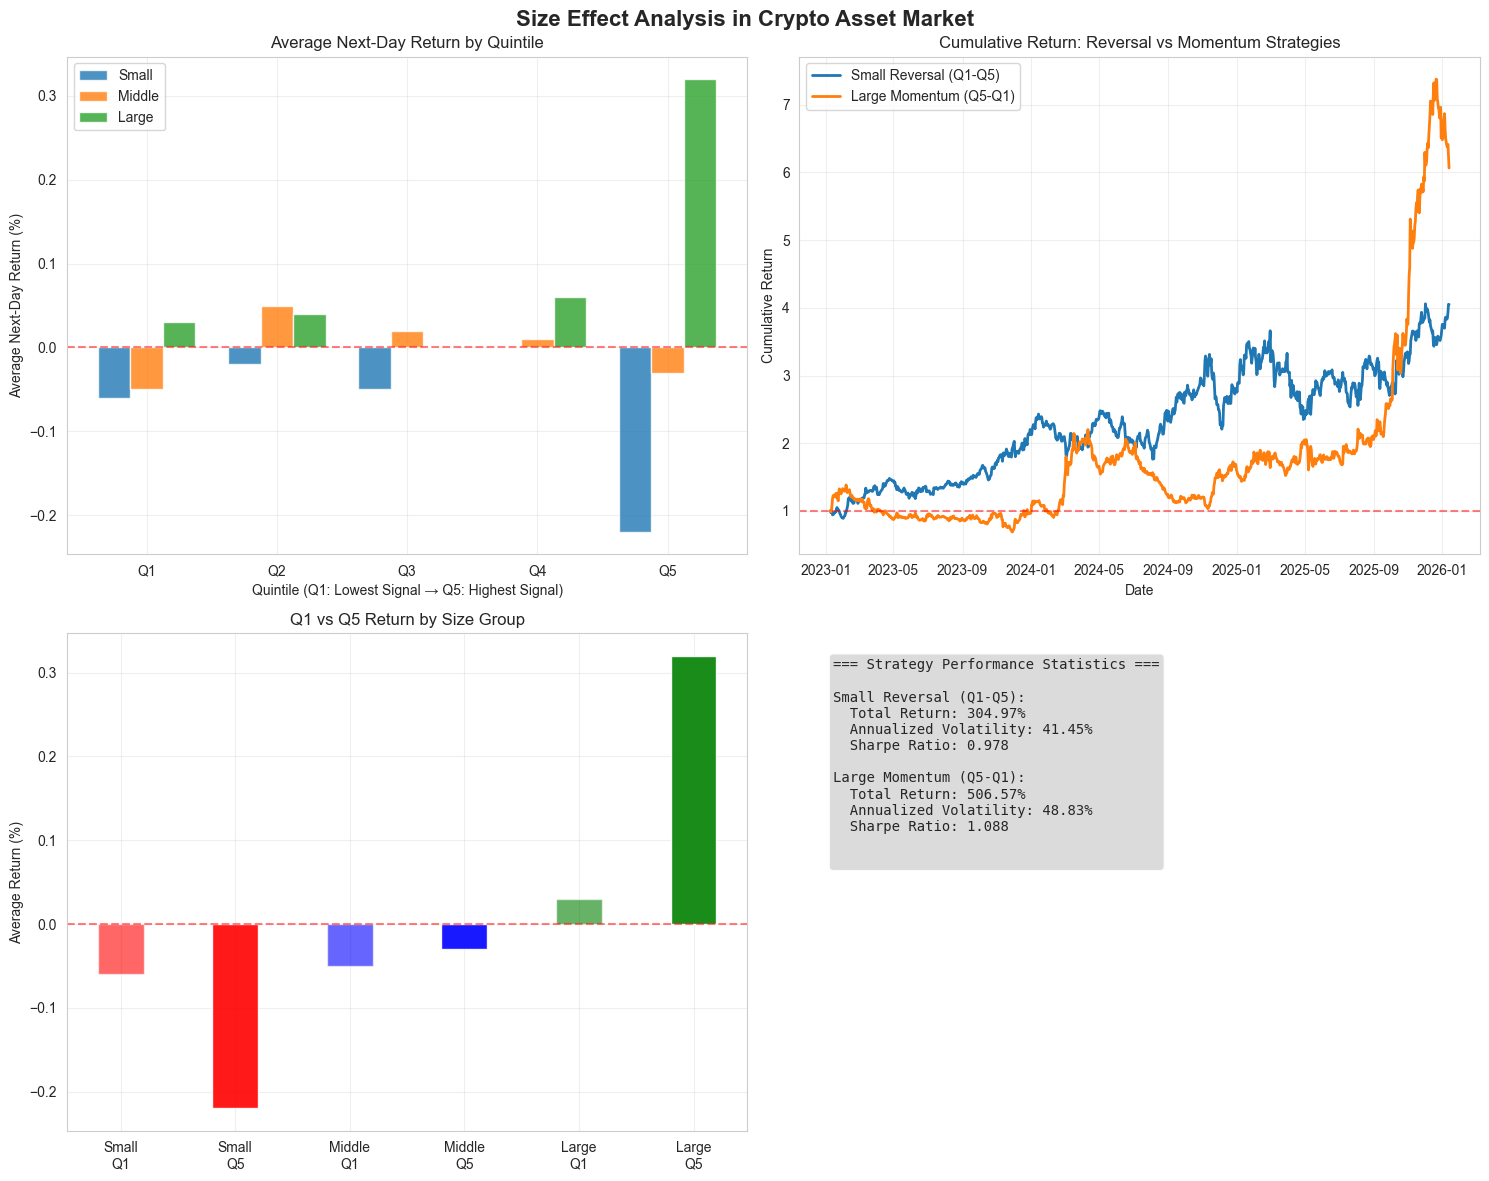

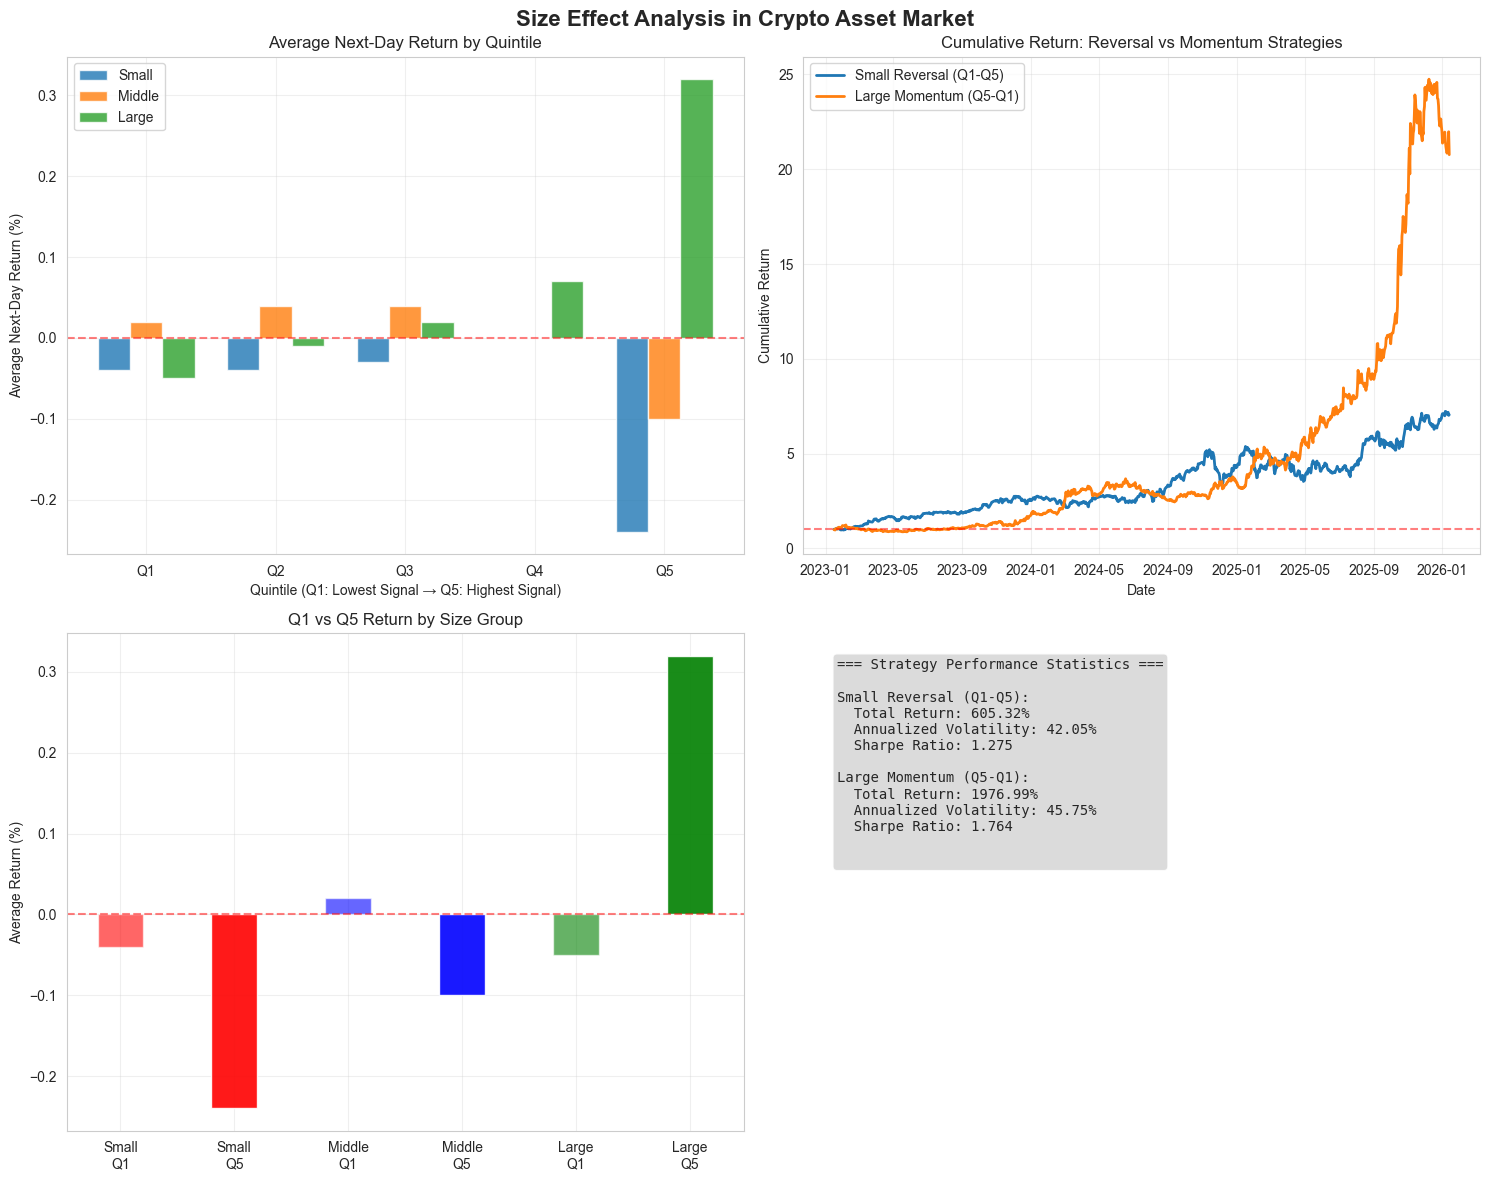

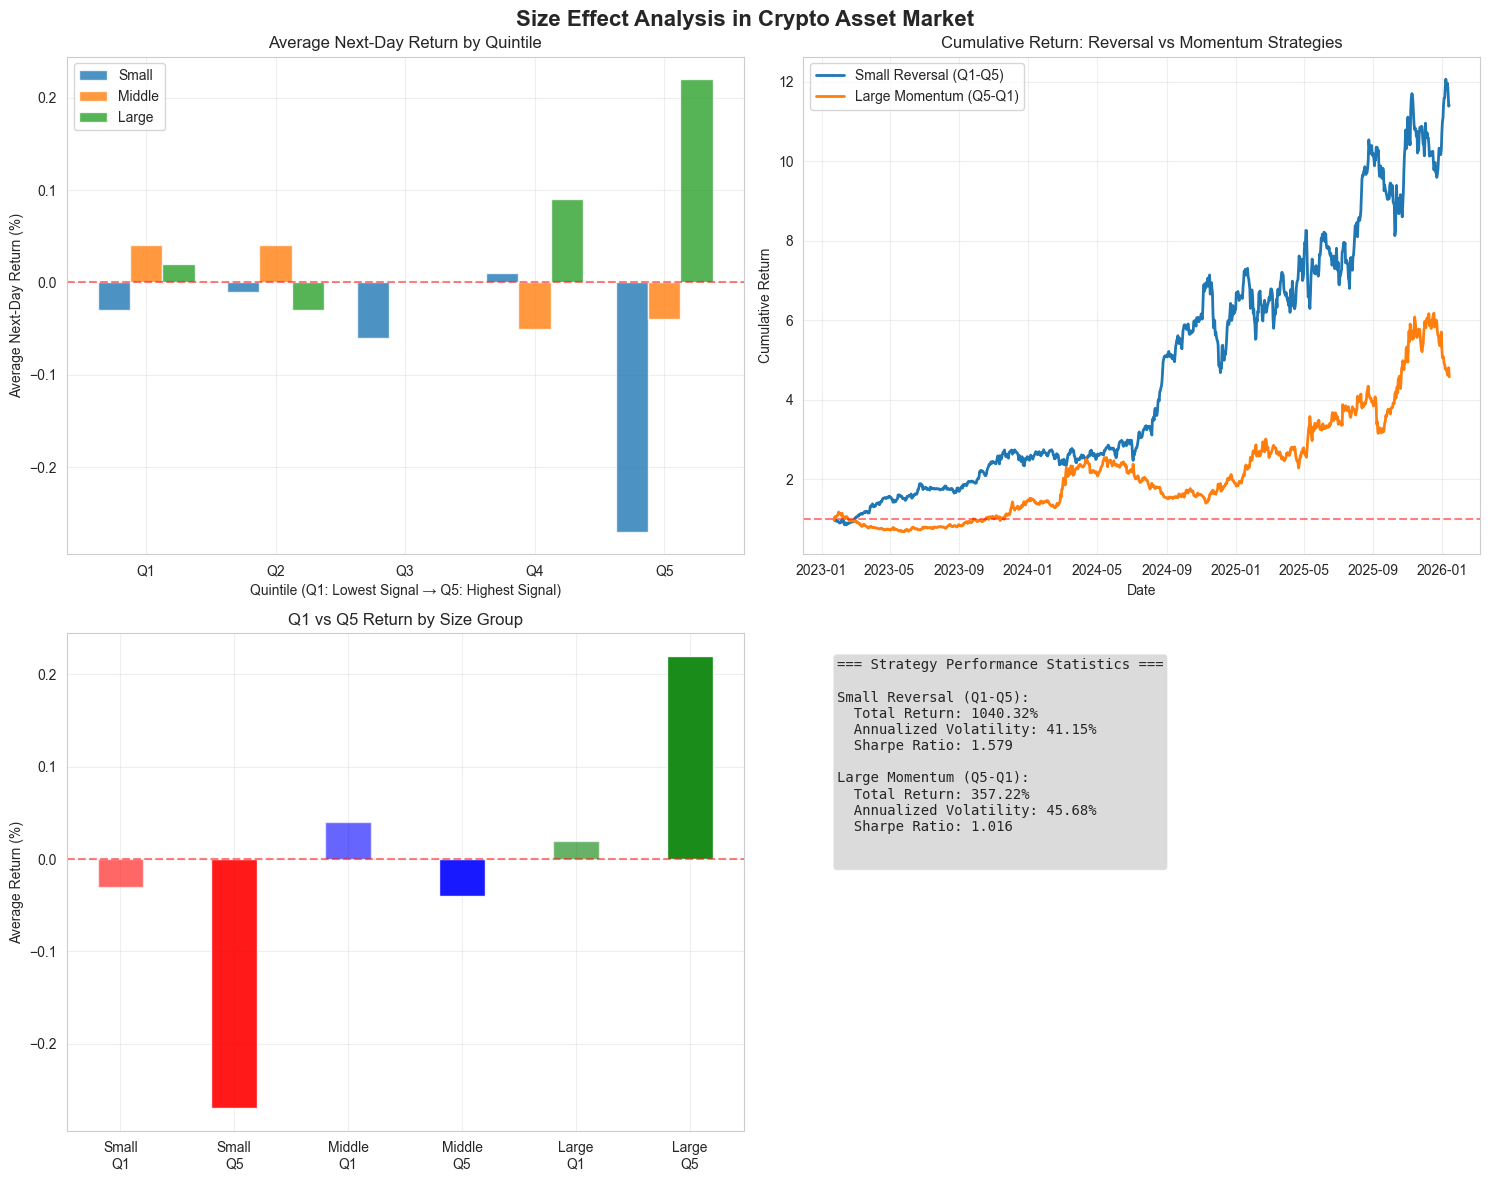

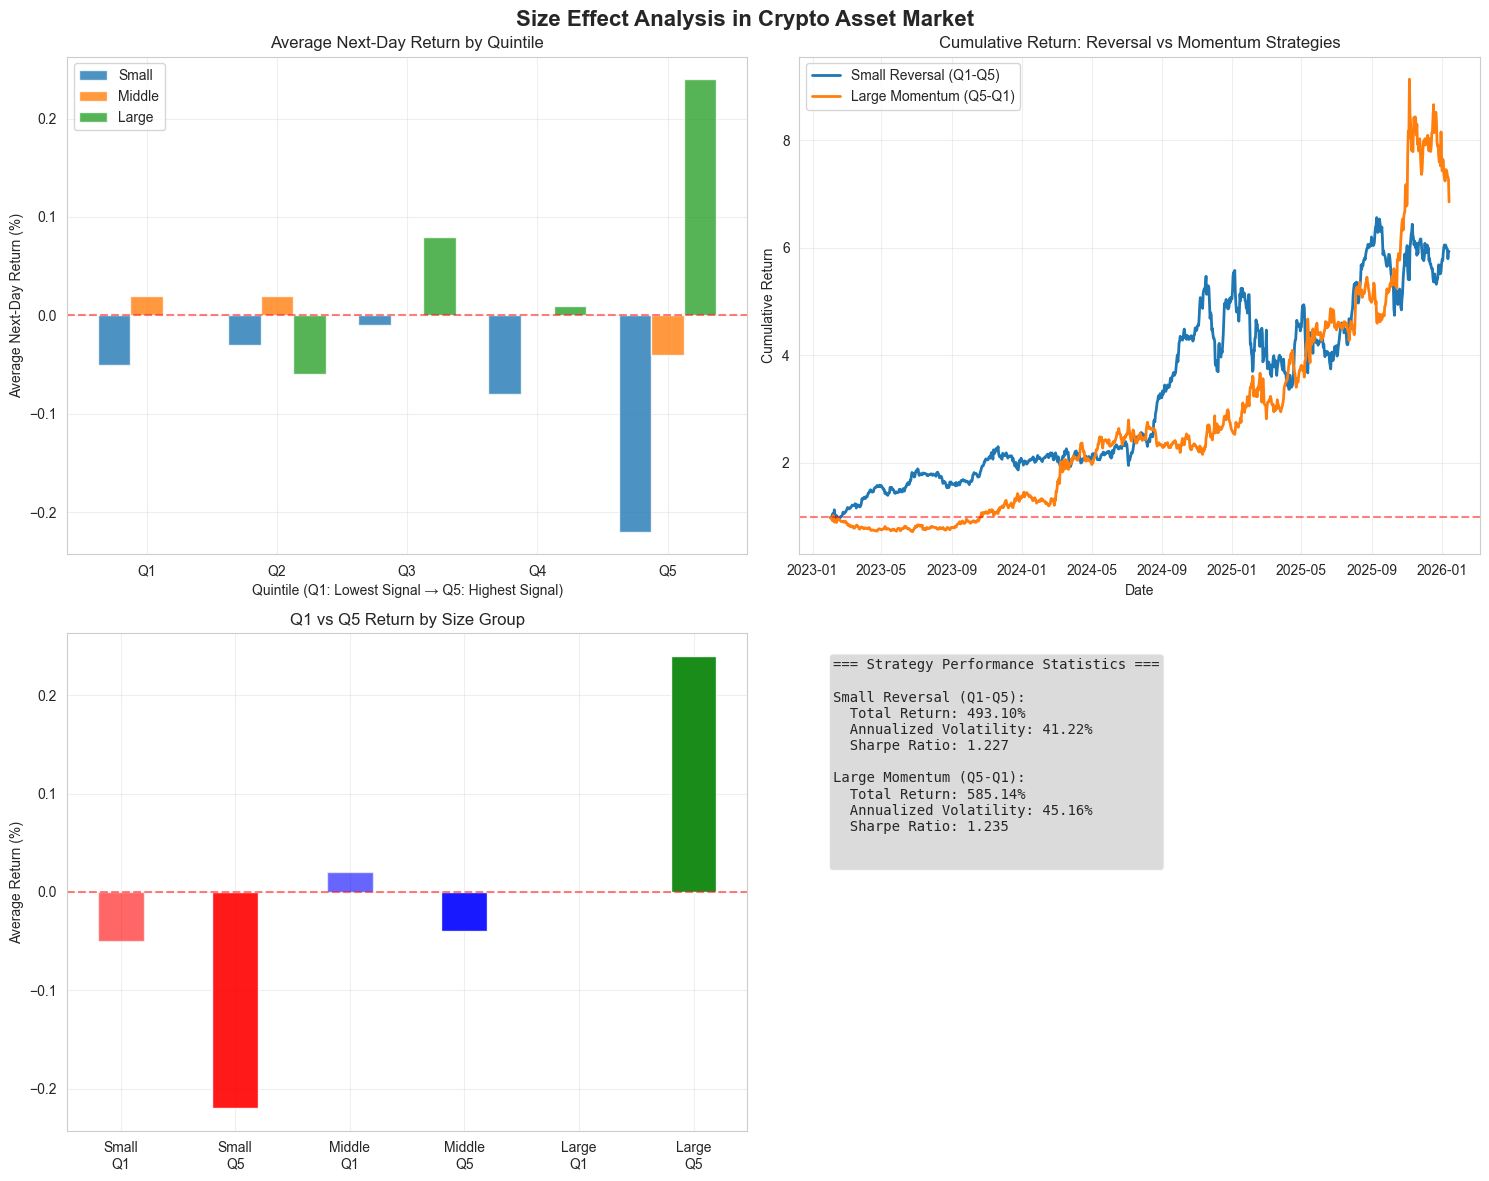

可視化完了


In [50]:
# 7. 結果の可視化

def plot_size_effect_analysis(quintile_results, daily_returns_data):
    """
    サイズ効果の分析結果を可視化
    """
    
    # 図のセットアップ
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Size Effect Analysis in Crypto Asset Market', fontsize=16, fontweight='bold')

    # 1. Comparison of average next-day return by quintile (bar chart)
    ax1 = axes[0, 0]

    x_pos = np.arange(5)
    width = 0.25

    for i, size_group in enumerate(['Small', 'Middle', 'Large']):
        if size_group in quintile_results:
            returns = quintile_results[size_group]['next_day_return']['mean'].values * 100
            ax1.bar(x_pos + i*width, returns, width, 
                   label=f'{size_group}', alpha=0.8)

    ax1.set_xlabel('Quintile (Q1: Lowest Signal → Q5: Highest Signal)')
    ax1.set_ylabel('Average Next-Day Return (%)')
    ax1.set_title('Average Next-Day Return by Quintile')
    ax1.set_xticks(x_pos + width)
    ax1.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # 2. 累積リターンの比較（ライングラフ）
    ax2 = axes[0, 1]
    
    strategies = {}
    
    for size_group in ['Small', 'Large']:
        if size_group in daily_returns_data:
            daily_data = daily_returns_data[size_group]
            
            if size_group == 'Small':
                # 小型株: リバーサル戦略 (Q1 - Q5)
                if 'Q1' in daily_data.columns and 'Q5' in daily_data.columns:
                    strategy_returns = daily_data['Q1'] - daily_data['Q5']
                    strategy_returns = strategy_returns.fillna(0)
                    cumulative = (1 + strategy_returns).cumprod()
                    strategies[f'{size_group} Reversal (Q1-Q5)'] = cumulative
                    
            else:  # Large
                # 大型株: モメンタム戦略 (Q5 - Q1)
                if 'Q1' in daily_data.columns and 'Q5' in daily_data.columns:
                    strategy_returns = daily_data['Q5'] - daily_data['Q1']
                    strategy_returns = strategy_returns.fillna(0)
                    cumulative = (1 + strategy_returns).cumprod()
                    strategies[f'{size_group} Momentum (Q5-Q1)'] = cumulative
    
    for strategy_name, cumulative in strategies.items():
        ax2.plot(cumulative.index, cumulative.values, 
                label=strategy_name, linewidth=2)
    
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Return')
    ax2.set_title('Cumulative Return: Reversal vs Momentum Strategies')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    
    # 3. サイズ別のリターン分布（ヒストグラム）
    ax3 = axes[1, 0]

    colors = ['red', 'blue', 'green']
    for i, size_group in enumerate(['Small', 'Middle', 'Large']):
        if size_group in quintile_results:
            # Q1とQ5の平均リターンを取得
            q1_return = quintile_results[size_group]['next_day_return']['mean'].iloc[0] * 100
            q5_return = quintile_results[size_group]['next_day_return']['mean'].iloc[-1] * 100

            ax3.bar([f'{size_group}\nQ1'], [q1_return], color=colors[i], alpha=0.6, width=0.4)
            ax3.bar([f'{size_group}\nQ5'], [q5_return], color=colors[i], alpha=0.9, width=0.4)

    ax3.set_ylabel('Average Return (%)')
    ax3.set_title('Q1 vs Q5 Return by Size Group')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    # 4. 戦略のパフォーマンス統計
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Display strategy statistics
    stats_text = "=== Strategy Performance Statistics ===\n\n"
    
    for strategy_name, cumulative in strategies.items():
        if len(cumulative) > 1:
            total_return = (cumulative.iloc[-1] - 1) * 100
            daily_returns = cumulative.pct_change().dropna()
            volatility = daily_returns.std() * np.sqrt(252) * 100
            sharpe = (daily_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252)) if daily_returns.std() > 0 else 0

            stats_text += f"{strategy_name}:\n"
            stats_text += f"  Total Return: {total_return:.2f}%\n"
            stats_text += f"  Annualized Volatility: {volatility:.2f}%\n"
            stats_text += f"  Sharpe Ratio: {sharpe:.3f}\n\n"

    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    plt.tight_layout()
    plt.show()

    return strategies

# 可視化の実行
if 'quintile_results' in locals() and 'daily_returns_data' in locals():
    strategy_performance_7days = plot_size_effect_analysis(quintile_results_7days, daily_returns_data_7days)
    strategy_performance_14days = plot_size_effect_analysis(quintile_results_14days, daily_returns_data_14days)
    strategy_performance_21days = plot_size_effect_analysis(quintile_results_21days, daily_returns_data_21days)
    strategy_performance_30days = plot_size_effect_analysis(quintile_results_30days, daily_returns_data_30days)
    print("可視化完了")
else:
    print("分析結果が見つかりません。前のセルを実行してください。")


In [24]:
# 8. 結果の解釈とまとめ

def interpret_results(quintile_results, strategy_performance):
    """
    分析結果の解釈とまとめを表示
    """
    
    print("=" * 60)
    print("暗号資産市場におけるサイズ効果の検証結果")
    print("=" * 60)
    
    # 各サイズグループの特性分析
    for size_group in ['Small', 'Middle', 'Large']:
        if size_group in quintile_results:
            print(f"\n【{size_group}サイズグループ】")
            
            q1_ret = quintile_results[size_group]['next_day_return']['mean'].iloc[0] * 100
            q5_ret = quintile_results[size_group]['next_day_return']['mean'].iloc[-1] * 100
            spread = q5_ret - q1_ret
            
            print(f"Q1 (低シグナル) 平均リターン: {q1_ret:.3f}%")
            print(f"Q5 (高シグナル) 平均リターン: {q5_ret:.3f}%")
            print(f"スプレッド (Q5-Q1): {spread:.3f}%")
            
            # トレンド判定
            if size_group == 'Small':
                if q1_ret > q5_ret:
                    print("→ リバーサル特性あり（低シグナル銘柄が翌日上昇）")
                else:
                    print("→ モメンタム特性（高シグナル銘柄が翌日上昇）")
            else:
                if q5_ret > q1_ret:
                    print("→ モメンタム特性（高シグナル銘柄が翌日上昇）")
                else:
                    print("→ リバーサル特性（低シグナル銘柄が翌日上昇）")
    
    # 戦略パフォーマンスの評価
    print("\n" + "=" * 60)
    print("戦略パフォーマンス評価")
    print("=" * 60)
    
    if strategy_performance:
        for strategy_name, cumulative in strategy_performance.items():
            if len(cumulative) > 1:
                total_return = (cumulative.iloc[-1] - 1) * 100
                daily_rets = cumulative.pct_change().dropna()
                
                print(f"\n【{strategy_name}】")
                print(f"総リターン: {total_return:.2f}%")
                print(f"最終累積倍率: {cumulative.iloc[-1]:.3f}倍")
                
                if total_return > 0:
                    print("→ 収益性あり")
                else:
                    print("→ 収益性なし")
    
    # 仮説の検証結果
    print("\n" + "=" * 60)
    print("仮説検証結果")
    print("=" * 60)
    
    print("\n元の仮説:")
    print("- 大型銘柄: モメンタム（順張り）が効きやすい")
    print("- 小型銘柄: 強いリバーサル（逆張り）特性")
    
    print("\n検証結果:")
    
    # 小型株の検証
    if 'Small' in quintile_results:
        small_q1 = quintile_results['Small']['next_day_return']['mean'].iloc[0]
        small_q5 = quintile_results['Small']['next_day_return']['mean'].iloc[-1]
        
        if small_q1 > small_q5:
            print("✓ 小型銘柄のリバーサル特性が確認されました")
        else:
            print("✗ 小型銘柄のリバーサル特性は確認されませんでした")
    
    # 大型株の検証
    if 'Large' in quintile_results:
        large_q1 = quintile_results['Large']['next_day_return']['mean'].iloc[0]
        large_q5 = quintile_results['Large']['next_day_return']['mean'].iloc[-1]
        
        if large_q5 > large_q1:
            print("✓ 大型銘柄のモメンタム特性が確認されました")
        else:
            print("✗ 大型銘柄のモメンタム特性は確認されませんでした")
    
    print("\n" + "=" * 60)
    print("注意事項")
    print("=" * 60)
    print("1. この分析は過去データに基づく検証であり、将来の収益を保証するものではありません")
    print("2. 実際の取引では手数料、スリッページ等のコストを考慮する必要があります")
    print("3. 暗号資産市場は高いボラティリティを持つため、リスク管理が重要です")
    print("4. より長期間・多数の銘柄でのロバスト性確認が推奨されます")

# 結果解釈の実行
if 'quintile_results' in locals():
    if 'strategy_performance' in locals():
        interpret_results(quintile_results_14days, strategy_performance_14days)
    else:
        interpret_results(quintile_results_14days, {})
else:
    print("分析結果が見つかりません。前のセルをすべて実行してください。")


暗号資産市場におけるサイズ効果の検証結果

【Smallサイズグループ】
Q1 (低シグナル) 平均リターン: -0.040%
Q5 (高シグナル) 平均リターン: -0.240%
スプレッド (Q5-Q1): -0.200%
→ リバーサル特性あり（低シグナル銘柄が翌日上昇）

【Middleサイズグループ】
Q1 (低シグナル) 平均リターン: 0.020%
Q5 (高シグナル) 平均リターン: -0.100%
スプレッド (Q5-Q1): -0.120%
→ リバーサル特性（低シグナル銘柄が翌日上昇）

【Largeサイズグループ】
Q1 (低シグナル) 平均リターン: -0.050%
Q5 (高シグナル) 平均リターン: 0.320%
スプレッド (Q5-Q1): 0.370%
→ モメンタム特性（高シグナル銘柄が翌日上昇）

戦略パフォーマンス評価

【Small Reversal (Q1-Q5)】
総リターン: 605.37%
最終累積倍率: 7.054倍
→ 収益性あり

【Large Momentum (Q5-Q1)】
総リターン: 1979.06%
最終累積倍率: 20.791倍
→ 収益性あり

仮説検証結果

元の仮説:
- 大型銘柄: モメンタム（順張り）が効きやすい
- 小型銘柄: 強いリバーサル（逆張り）特性

検証結果:
✓ 小型銘柄のリバーサル特性が確認されました
✓ 大型銘柄のモメンタム特性が確認されました

注意事項
1. この分析は過去データに基づく検証であり、将来の収益を保証するものではありません
2. 実際の取引では手数料、スリッページ等のコストを考慮する必要があります
3. 暗号資産市場は高いボラティリティを持つため、リスク管理が重要です
4. より長期間・多数の銘柄でのロバスト性確認が推奨されます


In [ ]:
# 9. 実行手順とデモ

print("""
=== 実行手順 ===

このノートブックを実行するには、以下の手順に従ってください：

1. 【セル1】ライブラリのインポート
   - 必要なPythonライブラリをインストール・インポート
   - pip install ccxt pandas numpy matplotlib seaborn tqdm

2. 【セル2-3】Binance設定と銘柄取得
   - Binance先物取引所への接続設定
   - 対象銘柄の一覧取得

3. 【セル4】データ収集
   - 各銘柄の日足データをAPI経由で取得
   - 出来高フィルタリング（1M USD以上）
   - ※時間がかかります（数分～10分程度）

4. 【セル5】データ前処理
   - サイズ別グループ分け
   - 21日リターンシグナルの計算

5. 【セル6】5分位分析
   - シグナル強弱による銘柄分類
   - 翌日リターンの統計計算

6. 【セル7】可視化
   - 4つのグラフによる結果表示
   - 戦略パフォーマンスの比較

7. 【セル8】結果解釈
   - 仮説検証結果のまとめ
   - 注意事項の確認

=== 注意事項 ===

• APIレート制限のため、データ取得には時間がかかります
• インターネット接続が必要です
• 50銘柄での検証に制限していますが、全銘柄でも可能です
• 実際の投資判断には使用せず、学習・研究目的でご利用ください

=== トラブルシューティング ===

• ccxtのインポートエラー: pip install ccxt
• データ取得エラー: ネットワーク接続を確認
• メモリエラー: 対象銘柄数を減らしてください（symbols[:20]等）
""")
